In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import mdtraj  as md
from math import log, log2, log10, exp
from matplotlib.collections import LineCollection
import matplotlib
font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 15}

matplotlib.rc('font', **font)
matplotlib.rc('font',**{'sans-serif':['Helvetica'], 'weight': 'medium', 'size':22})
import seaborn as sns
sns.color_palette("cubehelix")
import random
import pandas as pd
from hmmlearn import hmm

cmap = matplotlib.cm.get_cmap('cubehelix')
colors = []
for i in range(10):
    colors.append(cmap(i/10))

# Set HMM functions

In [2]:
def smooth_assignments(assignments, window_size):
    smoothed = np.zeros(len(assignments))
    
    for index in range(window_size, len(assignments)-window_size):
        smoothed[index] = np.bincount(assignments[index-window_size:index+window_size]).argmax()
    
    smoothed[0:window_size] = np.bincount(assignments[0:window_size]).argmax()
    smoothed[(len(assignments)-window_size):] = np.bincount(assignments[len(assignments)-window_size-1:]).argmax()
    
    return smoothed.astype(int)
    

np.random.seed(98423)

def get_window_start(data_series, window_size):
    for j in (range(4,0, -1)):
        
        if j == 1:
            plt.title("Raw GBM Input Data: Protein " + str(i)) 
            plt.xlabel('Frame #')
            plt.ylabel('tICA Coordinate-Based CV')
            plt.plot(t, data_series, color ='blue')
            plt.axvline(0,color="orange", linewidth=4)
            
            this_fig = plt.gcf()
            #this_fig.savefig("./raw_data_plots/protein_" + str(i) + "_raw_data.png", dpi=150)
            plt.show()
            
            
            #print("True number of states: 1\n")
            return 0
        
        remodel = hmm.GaussianHMM(n_components=j, covariance_type="full", n_iter=100)
        remodel.fit(data_series)
        state_assignments = remodel.predict(data_series)
        
        # smoothing twice to make sure all problematic noise is removed
        smoothed = smooth_assignments(smooth_assignments(state_assignments, window_size), window_size)
          
        #plt.title("State Assignmnets: Protein " + str(i)) 
        #plt.ylabel('State Assignments')
        #plt.xlabel('Frame #')
        #plt.yticks(range(0, j))
        #plt.plot(state_assignments, color='blue')
        #this_fig = plt.gcf()
        #plt.show()
        
        #plt.title("State Assignmnets Smoothed: Protein " + str(i)) 
        #plt.ylabel('State Assignments')
        #plt.xlabel('Frame #')
        #plt.yticks(range(0, j))
        #plt.plot(smoothed, color='red')
        #this_fig = plt.gcf()
        #plt.show()
        
        
        start_index = len(smoothed) -1
        
        for index in range(len(smoothed)-1, 0, -1):
            if smoothed[index] == smoothed[-1]:
                start_index = index
            else:
                break
        
        #print("start_index: " + str(start_index))
        
        state_change_counter = 0
        
        if len(state_assignments[start_index:]) - 1 <= window_size * 4:
            print("Last state not sufficiently sampled!\n")
            continue
          
        for index in range(start_index, len(state_assignments) - 1):
            if state_assignments[index] != smoothed[-1]:
                state_change_counter += 1
            
        transition_rate = float(state_change_counter)/(len(state_assignments[start_index:])) 
        #print("% state deviation: " + str(transition_rate) + "\n")
        
        if transition_rate < 0.10:
            print("# of states:" + str(j) + ' start frame #:' + str(start_index))
            
            plt.title("Raw GBM Input Data: Protein " + str(i)) 
            plt.xlabel('Frame #')
            plt.ylabel('tICA Coordinate-Based CV')
            plt.plot(t, data_series, color ='blue')
            plt.axvline(start_index,color="orange", linewidth=4)
            this_fig = plt.gcf()
            plt.show()
            return start_index
        
        
        continue

# Normalize and get the ABS of the tICA DATA

In [3]:
def norm_all(x, mins, maxs):
    x1 = x
    for i in range(x.shape[0]):
        x1[i] = (x[i] - mins)/(maxs-mins)
    return x1
def abs_all(x):
    x1 = x[:, 0]
    x1 = abs(x1 - x[0, 0])
    x2 = x[:, 1]
    x2 = abs(x2 - x[0, 1])
    return np.stack((x1, x2), axis = -1)

# Upload tICA data

In [4]:
data = np.load('n22np_dataset.npy')
#plt.plot(data[120, :, 0])
ALL_tICA_DATA = [data[120, :, :2], data[121, :, :2], data[122, :, :2], data[123, :, :2], 
                data[124, :, :2], data[125, :, :2], data[126, :, :2], data[127, :, :2]]


In [5]:
ff = ['/your_path_to_h5_files/'+str(i))+'.h5' for i in range(60)] # individual tICA data for each trajectory

ALL_tICA_DATA = []
for filename in ff:
    with h5py.File(filename, "r") as f:
        # List all groups
        #print("Keys: %s" % f.keys())
        a_group_key = list(f.keys())[0]

        # Get the data
        data = list(f[a_group_key])

    k = np.concatenate(data)
    k = np.asarray(np.split(k, data[0].shape[0])).reshape(len(data), data[0].shape[0])
    ALL_tICA_DATA.append(k)

In [5]:
abs_data = []

for i in range(len(ALL_tICA_DATA)):
    abs_data.append(abs_all(ALL_tICA_DATA[i][:, :2]))
all_abs_data= np.concatenate(abs_data)
mins1 = np.min(all_abs_data[:, 0])
mins2 = np.min(all_abs_data[:, 1])
maxs1 = np.max(all_abs_data[:, 0])
maxs2 = np.max(all_abs_data[:, 1])

In [6]:
norm_abs_data_x = []
norm_abs_data_y = []
for i in range(len(ALL_tICA_DATA)):
    norm_abs_data_x.append(norm_all(abs_data[i][:, 0], mins1, maxs1))
    norm_abs_data_y.append(norm_all(abs_data[i][:, 1], mins2, maxs2))

# Extract the distance traveled for MSD calculation

In [7]:
k = []
for l in range(len(ALL_tICA_DATA)):
    x0 = ALL_tICA_DATA[l][0, 0]
    y0 = ALL_tICA_DATA[l][0, 1]
    s = ALL_tICA_DATA[l].shape[0]
    k.append((ALL_tICA_DATA[l][:, 0] - x0)**2+ (ALL_tICA_DATA[l][:, 1]-y0)**2)

A = []
for j in range(len(k)):
    av = []
    for r in range(k[j].shape[0]):
        av.append(np.average(k[j][:r]))
    A.append(np.asarray(av))

/Users/EDK4002/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/EDK4002/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Get GBM prediction for tIC 1, MSD plots, evaluated mu and the begining of the last diffusion regime

/Users/EDK4002/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/EDK4002/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/EDK4002/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


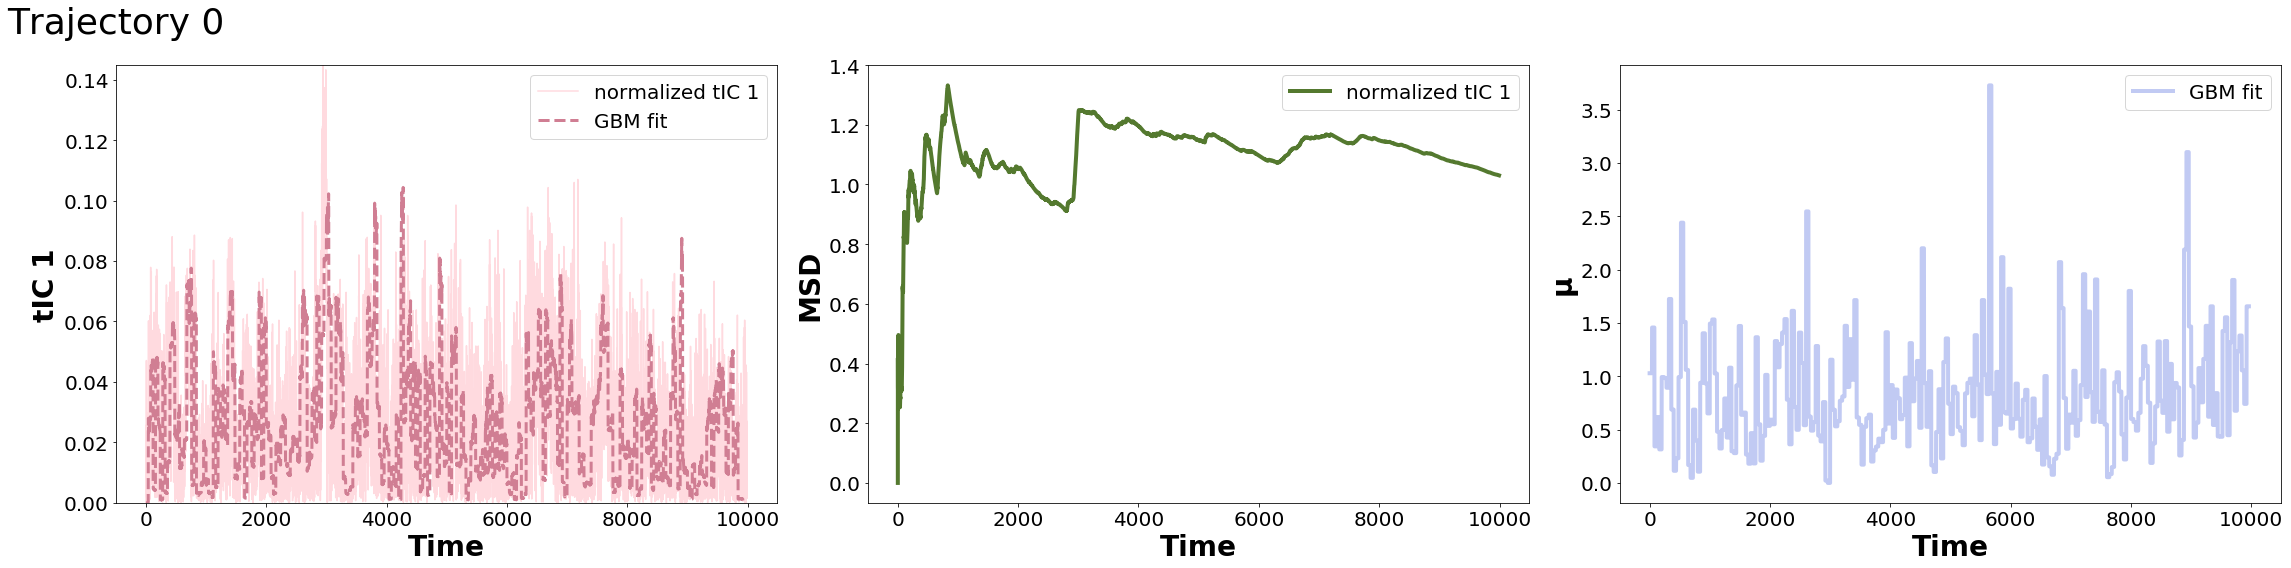

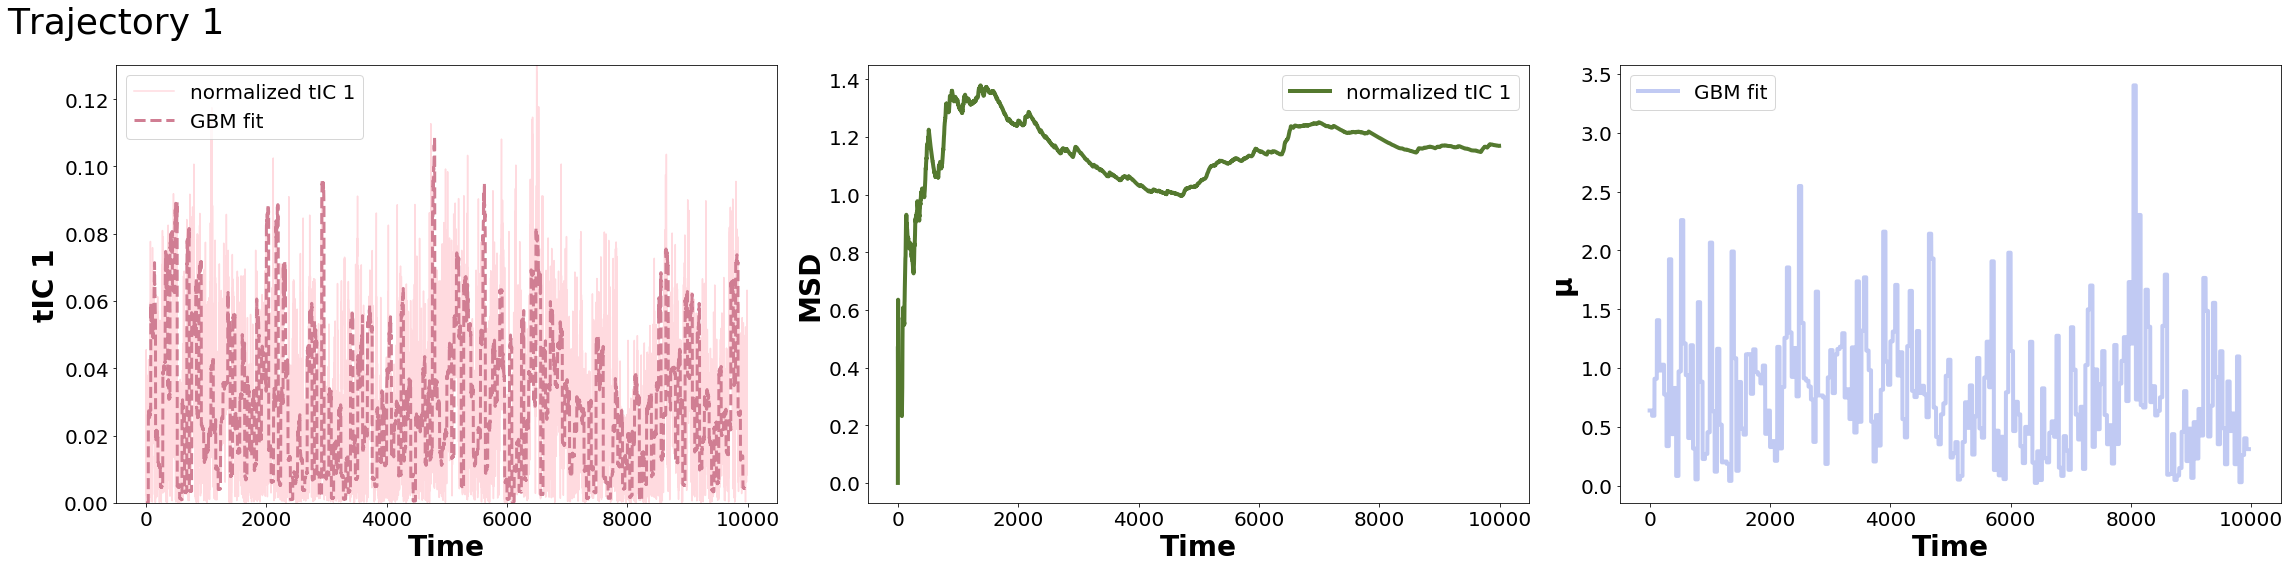

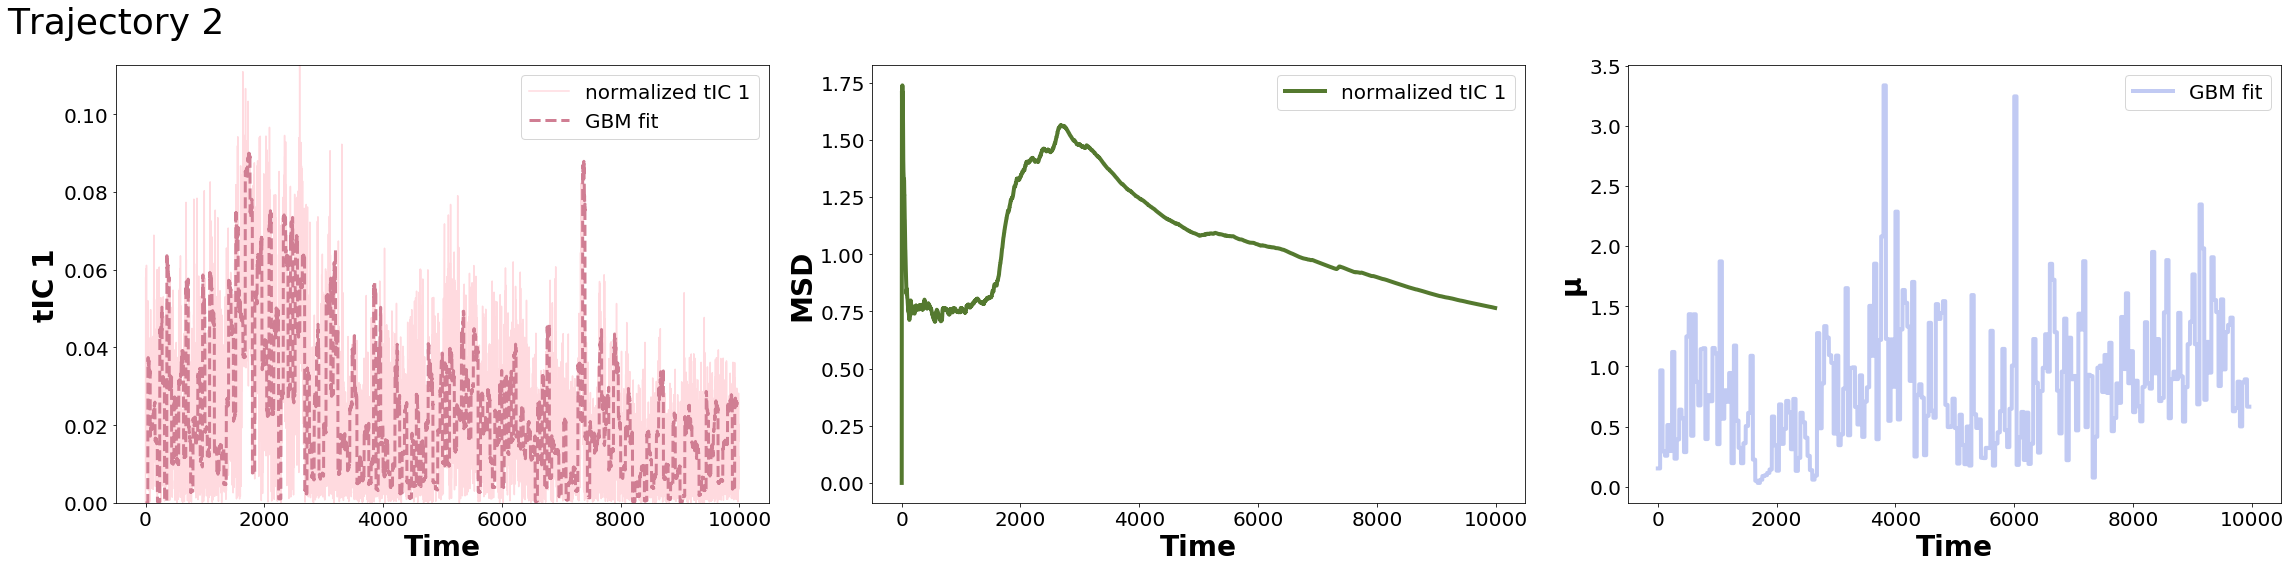

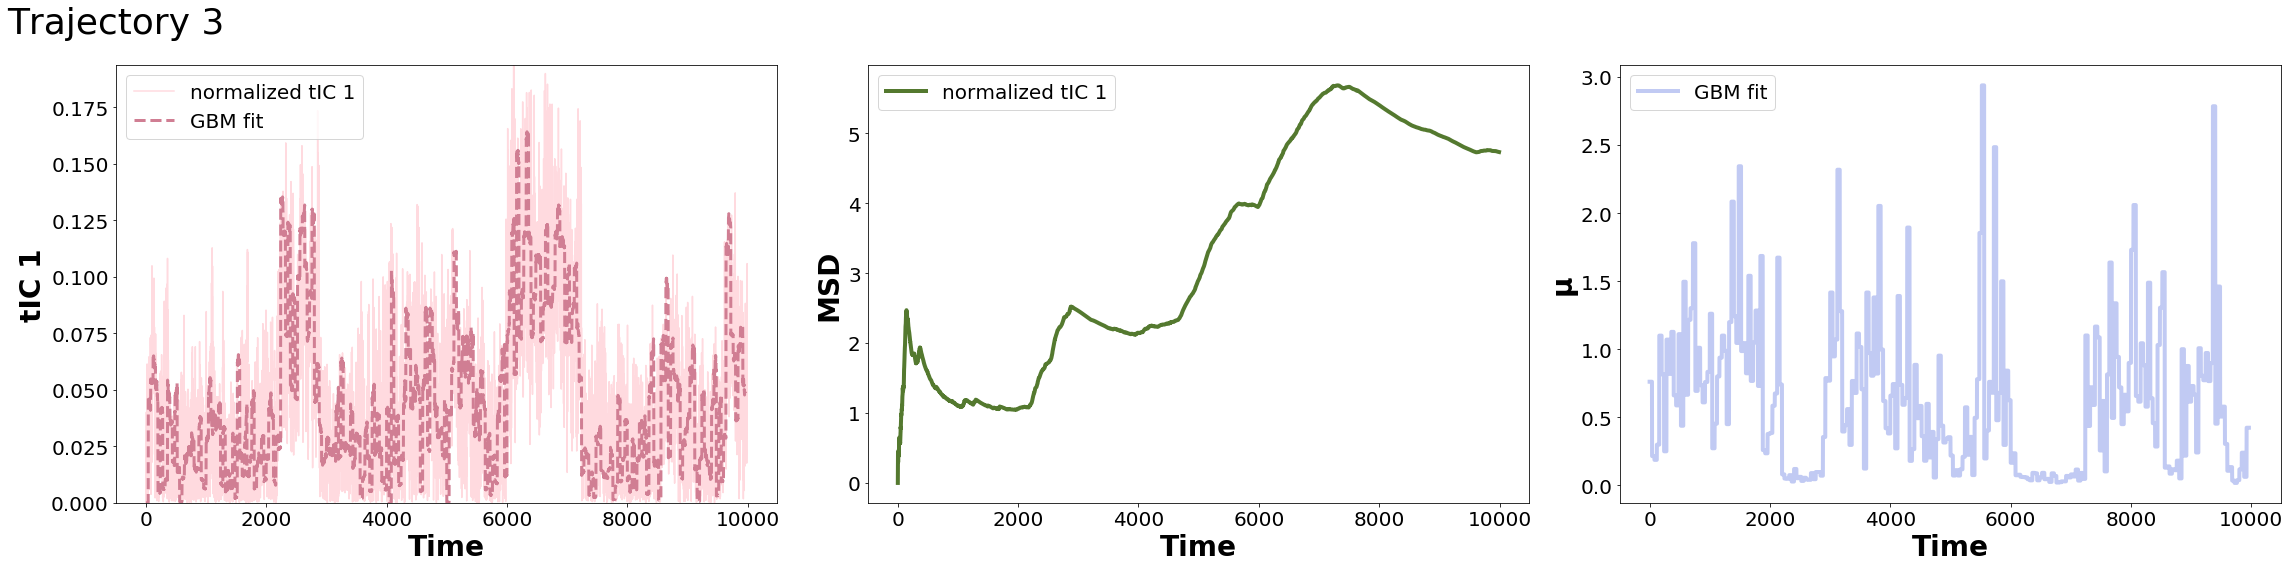

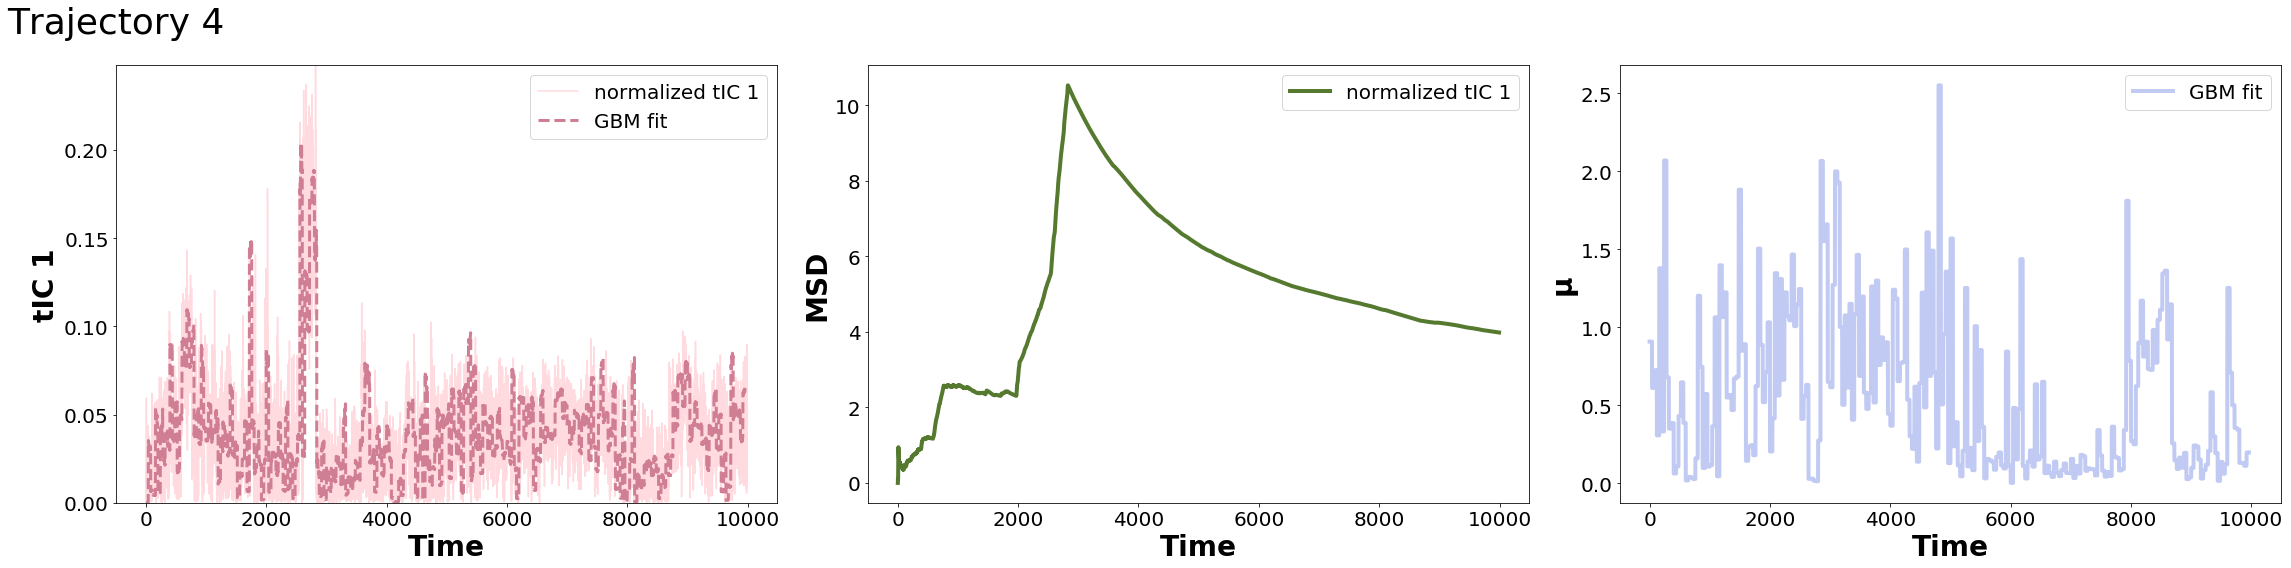

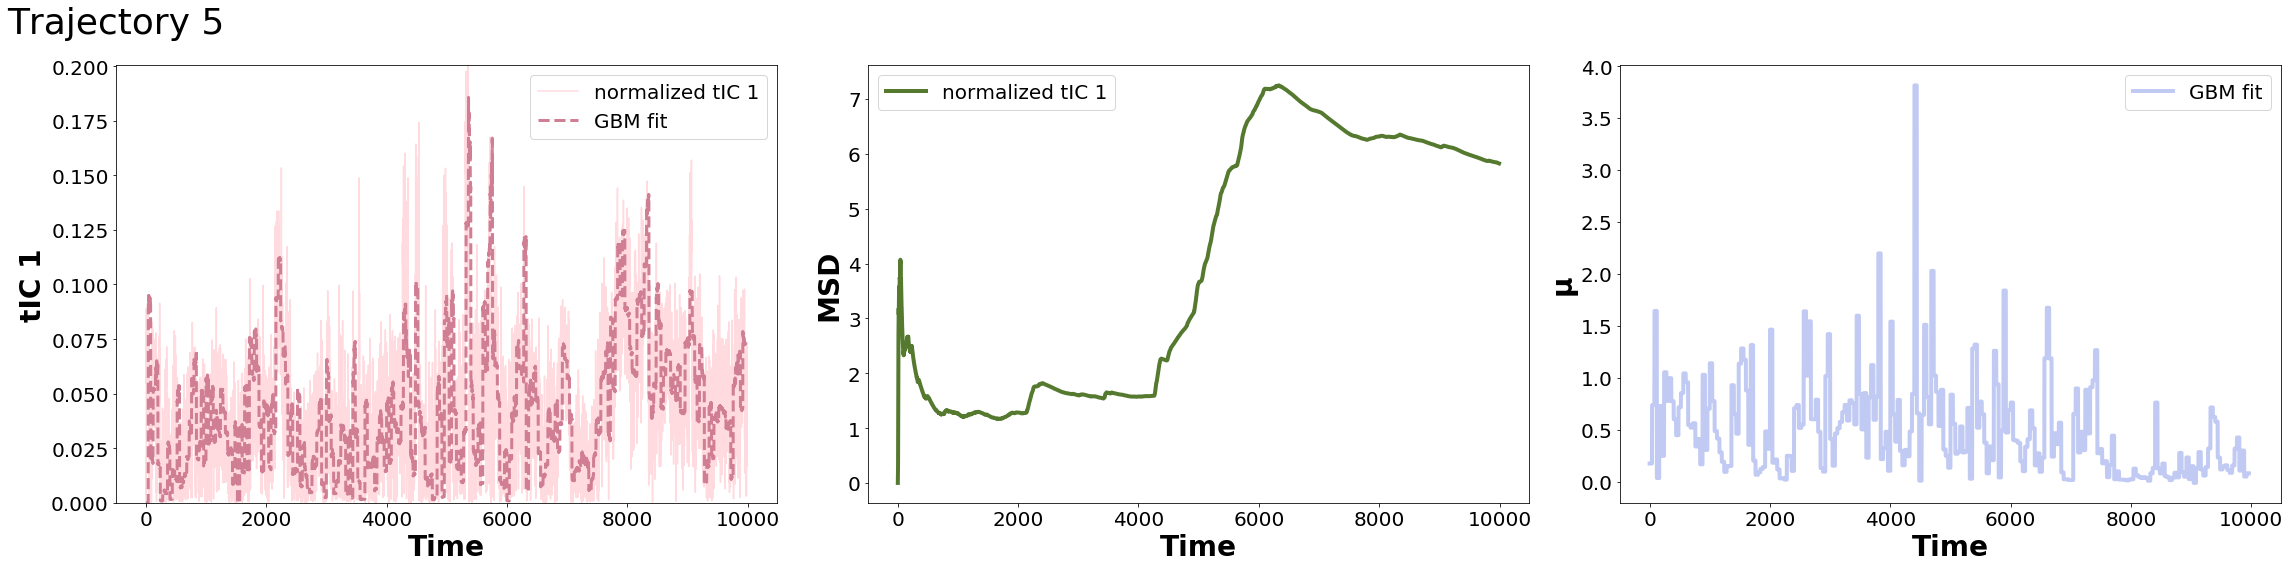

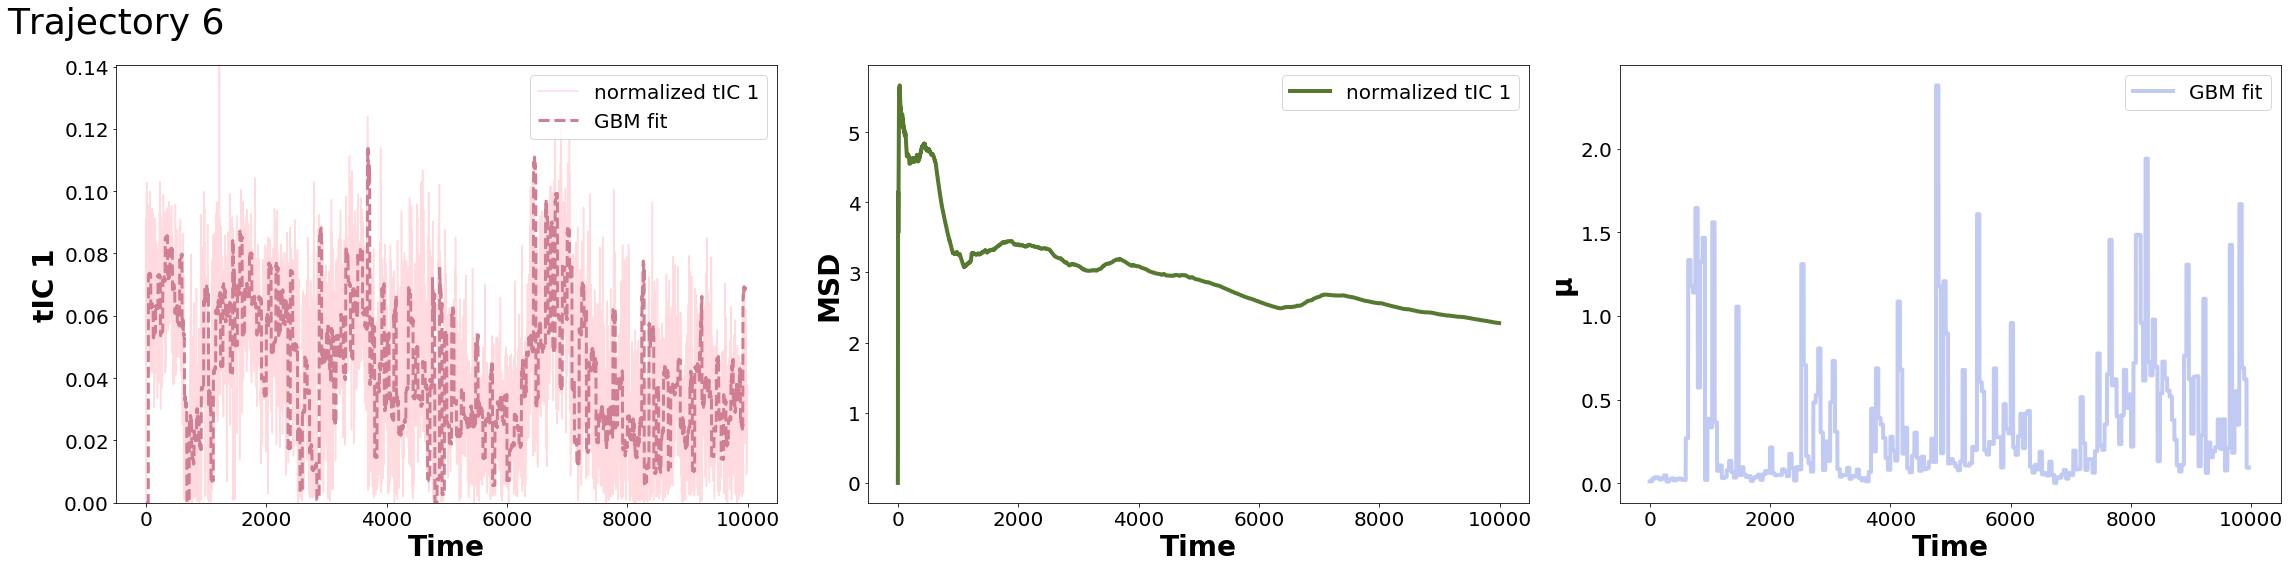

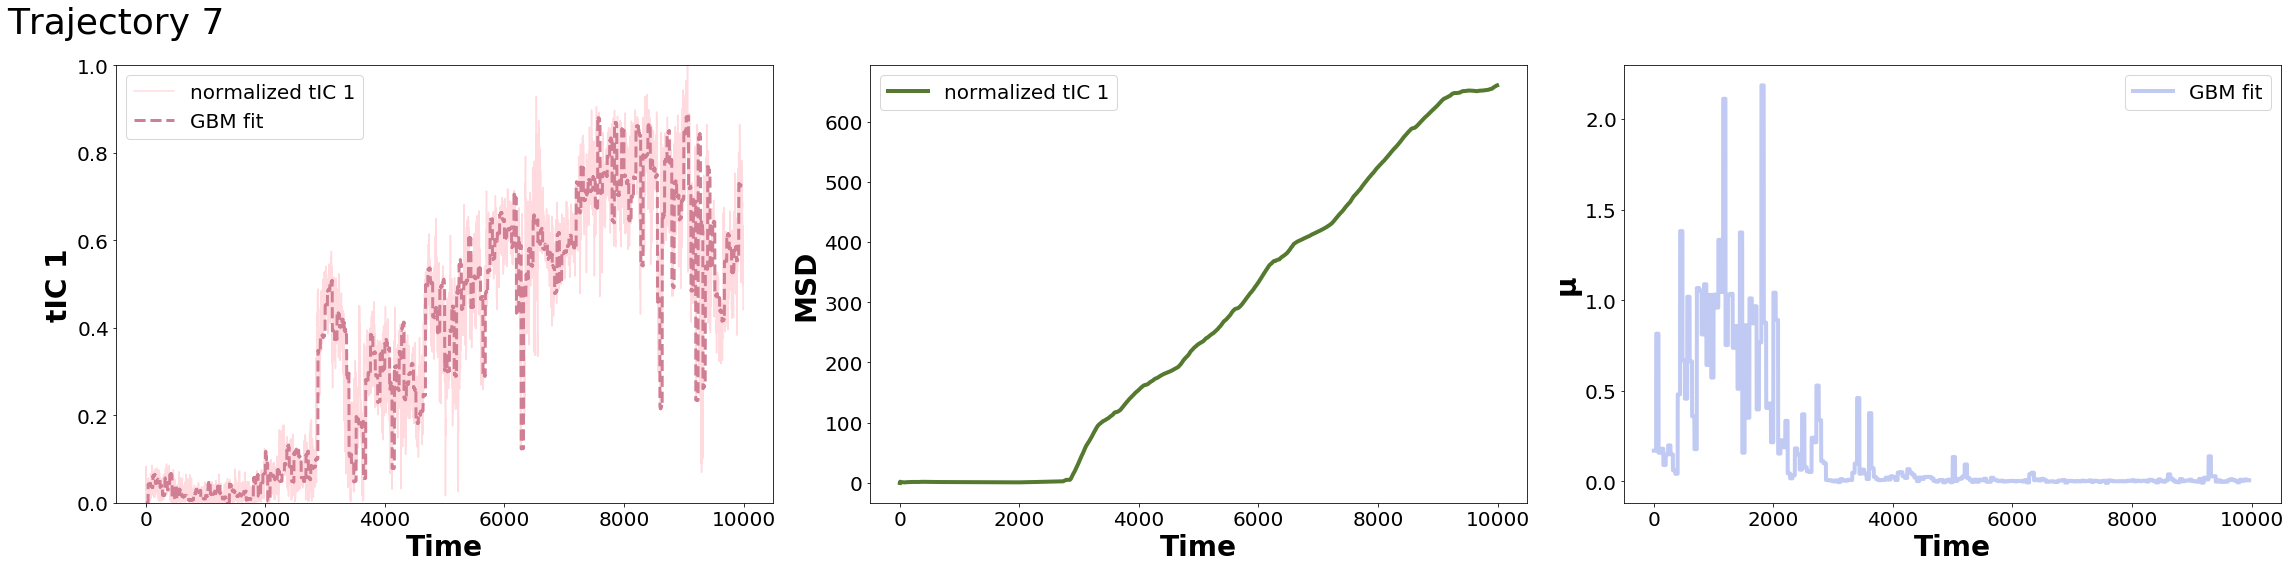

In [8]:
hg = 1  # the portion of the trajectory analyzed  (with 1 for using the whole length)
# tICA component 2

mu_1x = []
sigma2_1 = []
diff_2x = []
lag = 40
m_av = []
R = []
for i in range(8):
    shape = norm_abs_data_x[i].shape[0]//hg
    ss = []
    m = []
    for j in range(shape//lag):
        data1 = norm_abs_data_x[i][j*lag+1:(j+1)*lag]
        t = np.arange((j*lag+1)//10000, (j+1)*lag/10000)

        # Specify the data to be used in GBM analysis
        data  = data1
        xx = np.sum(np.log(data[1:]/data[:-1])[1:])  
        x_f = xx/data.shape[0]
        s = (1/(data.shape[0]-1))*np.sum((np.log(data[1:]/data[:-1])[1:]-x_f)**2)
        sigma3 = (s)**0.5
        mu3 = x_f+0.5*sigma3**2
        mu3 = round(mu3, 4)
        sigma2 = round(0.5*sigma3**2, 4)
        for g in range(lag):
            ss.append(sigma2)
            m.append(mu3)
    sigma2_1.append(np.asarray(ss))
    mu_1x.append(np.asarray(m))
    fig, ax = plt.subplots(figsize = (32, 8), ncols = 3, nrows = 1, sharex = True)
    ax[0].set_title('Trajectory '+str(i), x = 0, y=1.06, fontsize = 36)

    ax[2].plot(mu_1x[i], color = colors[8], lw = 4, label = 'GBM fit', zorder = 0)    
    ax[0].plot(norm_abs_data_x[i], color = 'lightpink', alpha = 0.5, label = 'normalized tIC 1')
    ax[1].plot(A[i], color = colors[4], lw = 4, label = 'normalized tIC 1')
    ax[1].set_ylabel("MSD", {'weight':'semibold'}, fontsize = 28)
    ax[2].set_ylabel(u"\u03bc", {'weight':'semibold'}, fontsize = 28)      
    XX = []
    TT = []
    for j in range(shape//lag):
        x0 = norm_abs_data_x[i][j*lag]
        mu3 = np.average(mu_1x[i][j*lag])
        sigma3 = np.average(sigma2_1[i][j*lag])
        dt = 0.0001

        t = np.arange(j*lag+1, (j+1)*lag)
        x = np.exp(
        (mu3 - sigma3 ) * dt
        + (2*sigma3**0.5) * np.random.normal(0, np.sqrt(dt), size=(len([sigma3]), lag-2)).T)
        x = np.vstack([np.ones(len([sigma3])), x])
        x = x0 * x.cumprod(axis=0)
        XX.append(x[:, 0])
        TT.append(t)
    ax[0].plot(np.concatenate(TT)-1, np.concatenate(XX), color = colors[6], lw = 3, linestyle = '--', label = 'GBM fit')
    ax[0].set_ylim(0, np.max(norm_abs_data_x[i]))
    ax[0].set_ylabel("tIC 1", {'weight':'semibold'}, fontsize = 28)
    plt.legend()
    for a in ax:
        a.legend(loc = 'best', prop = {'size': 20})
        a.set_xlabel('Time', {'weight':'semibold'}, fontsize = 28)
        a.tick_params(labelsize = 20)
    fig.tight_layout()


# Get GBM prediction for tIC 2, MSD plots, evaluated mu and the begining of the last diffusion regime

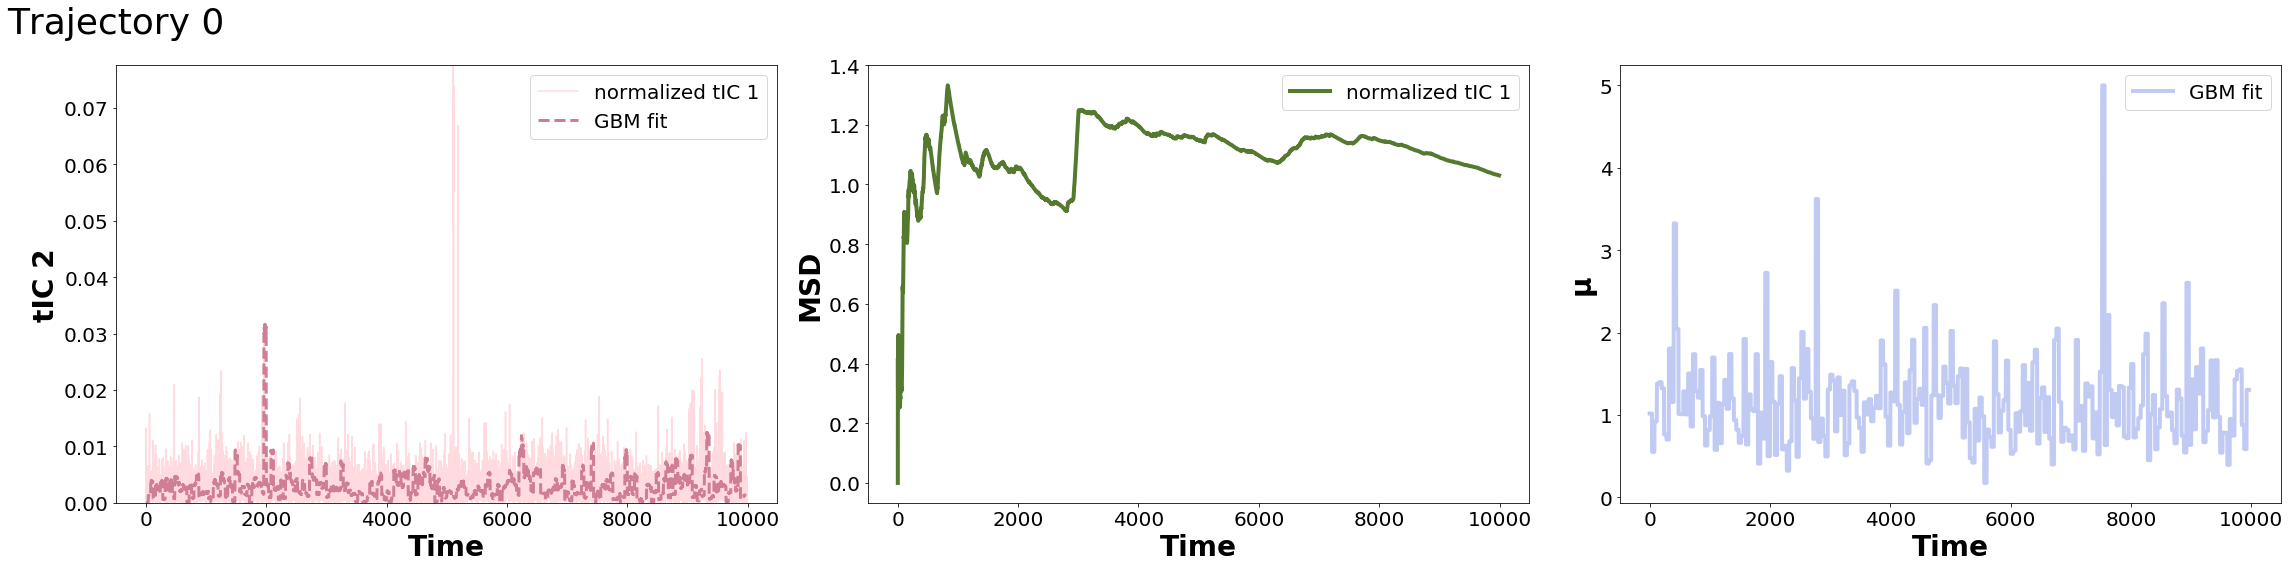

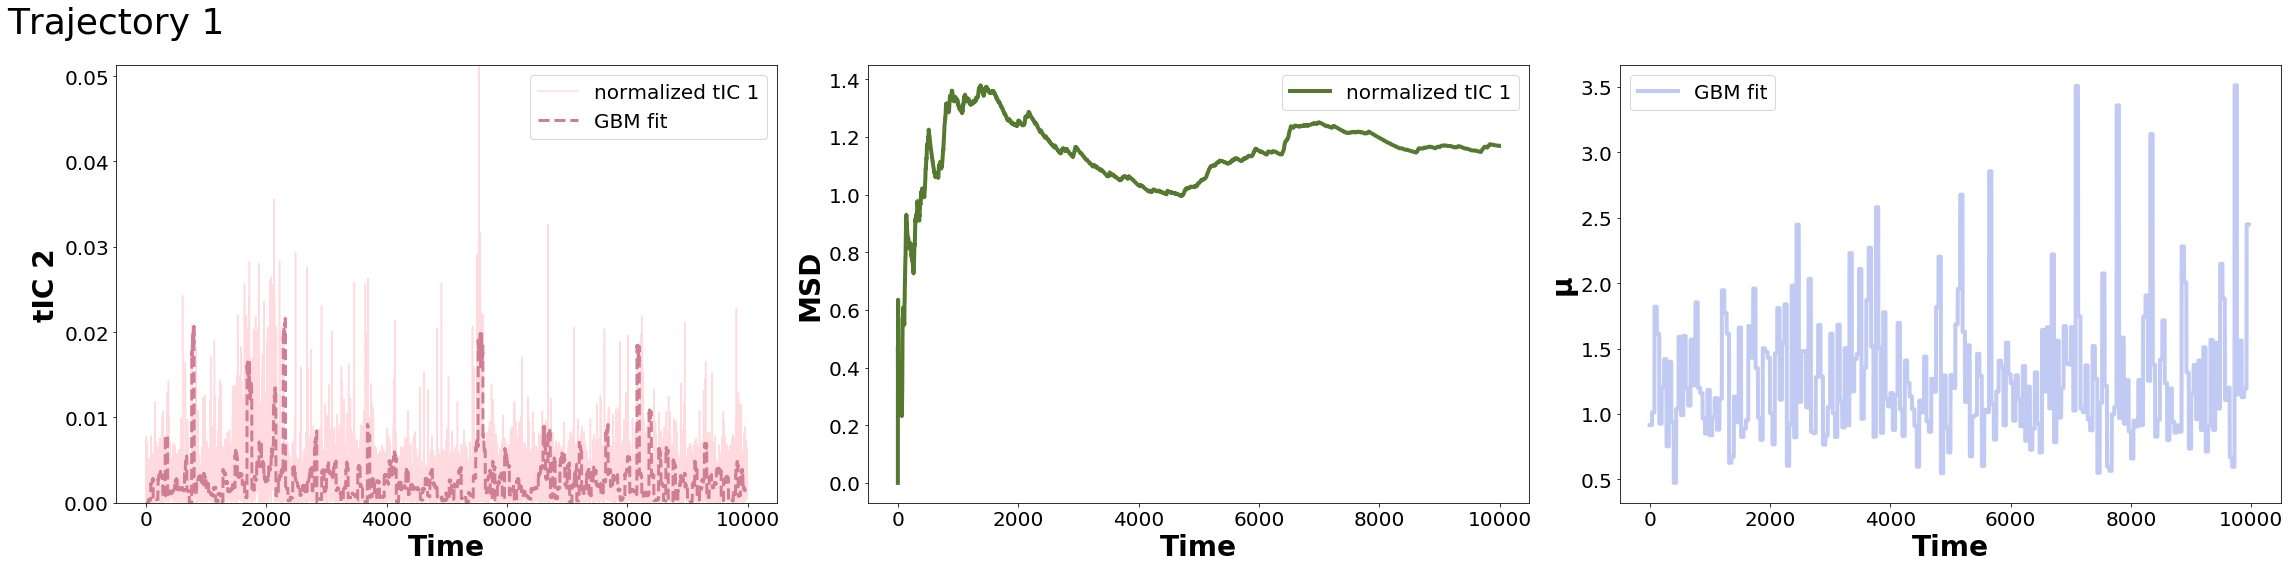

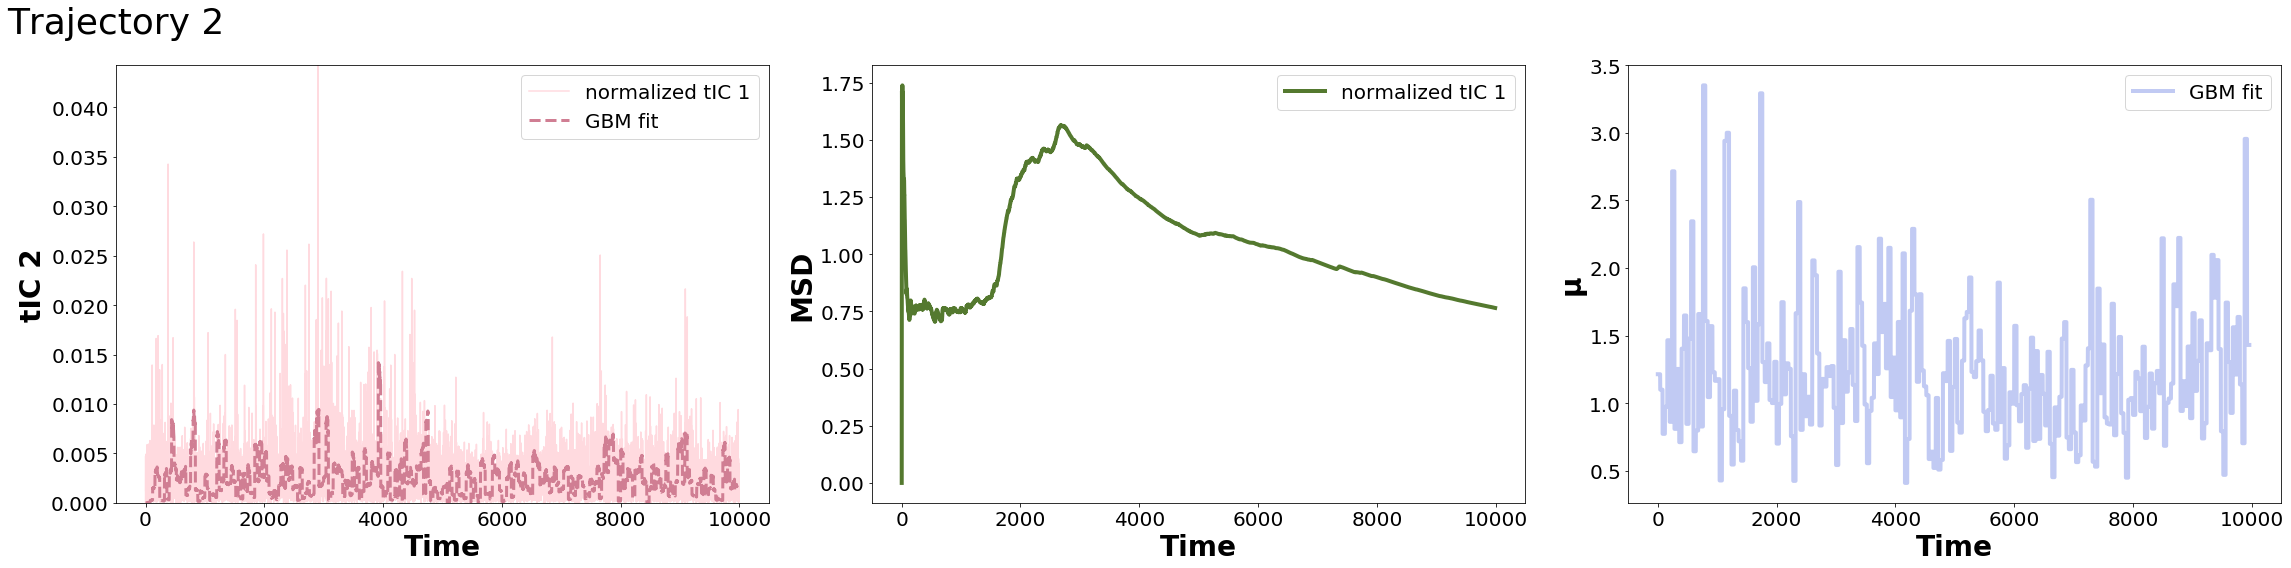

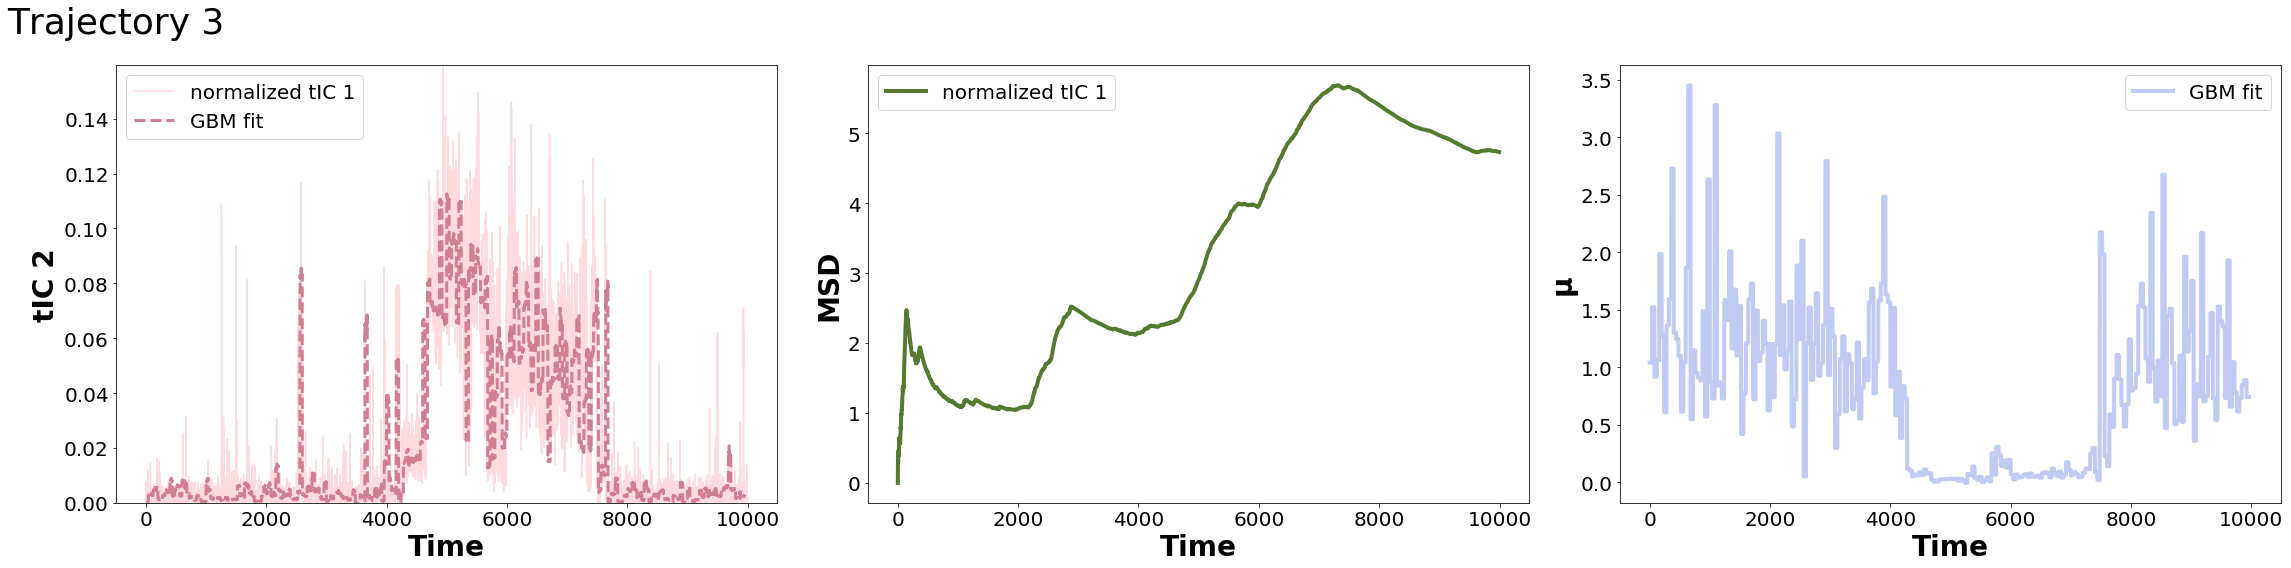

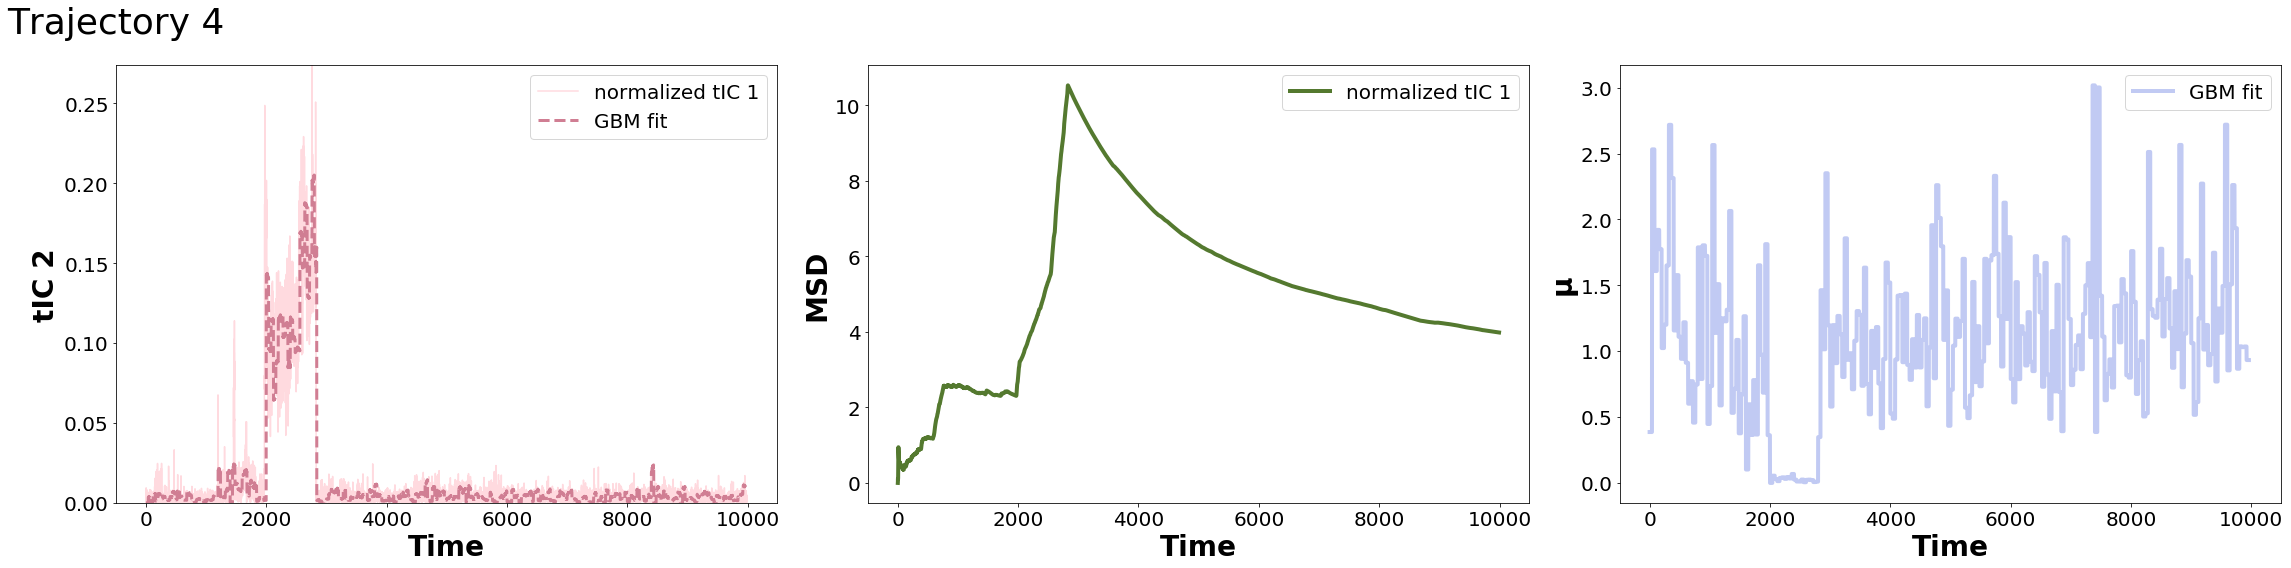

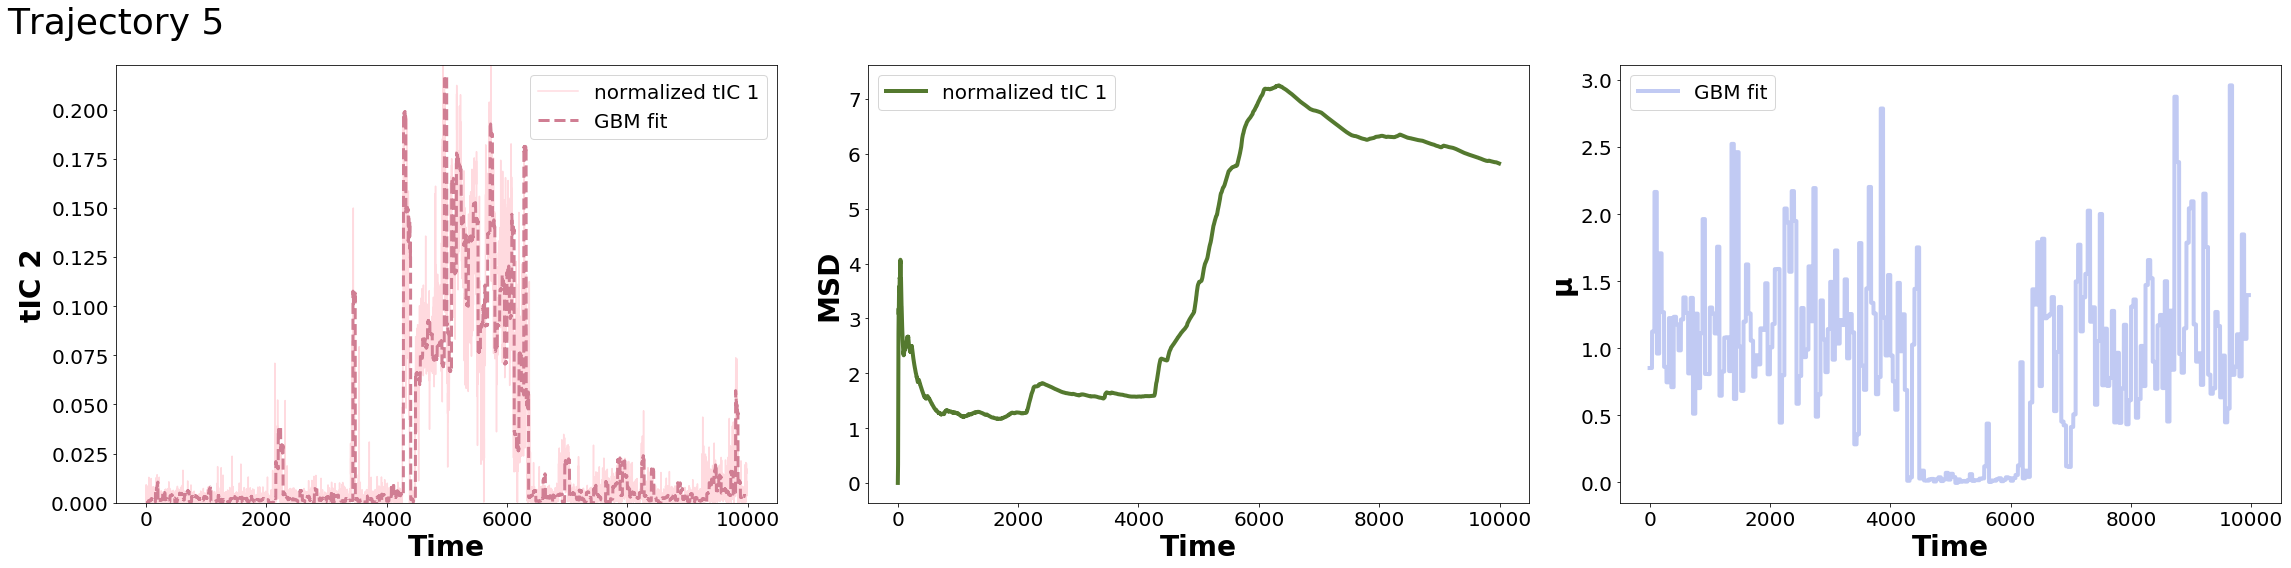

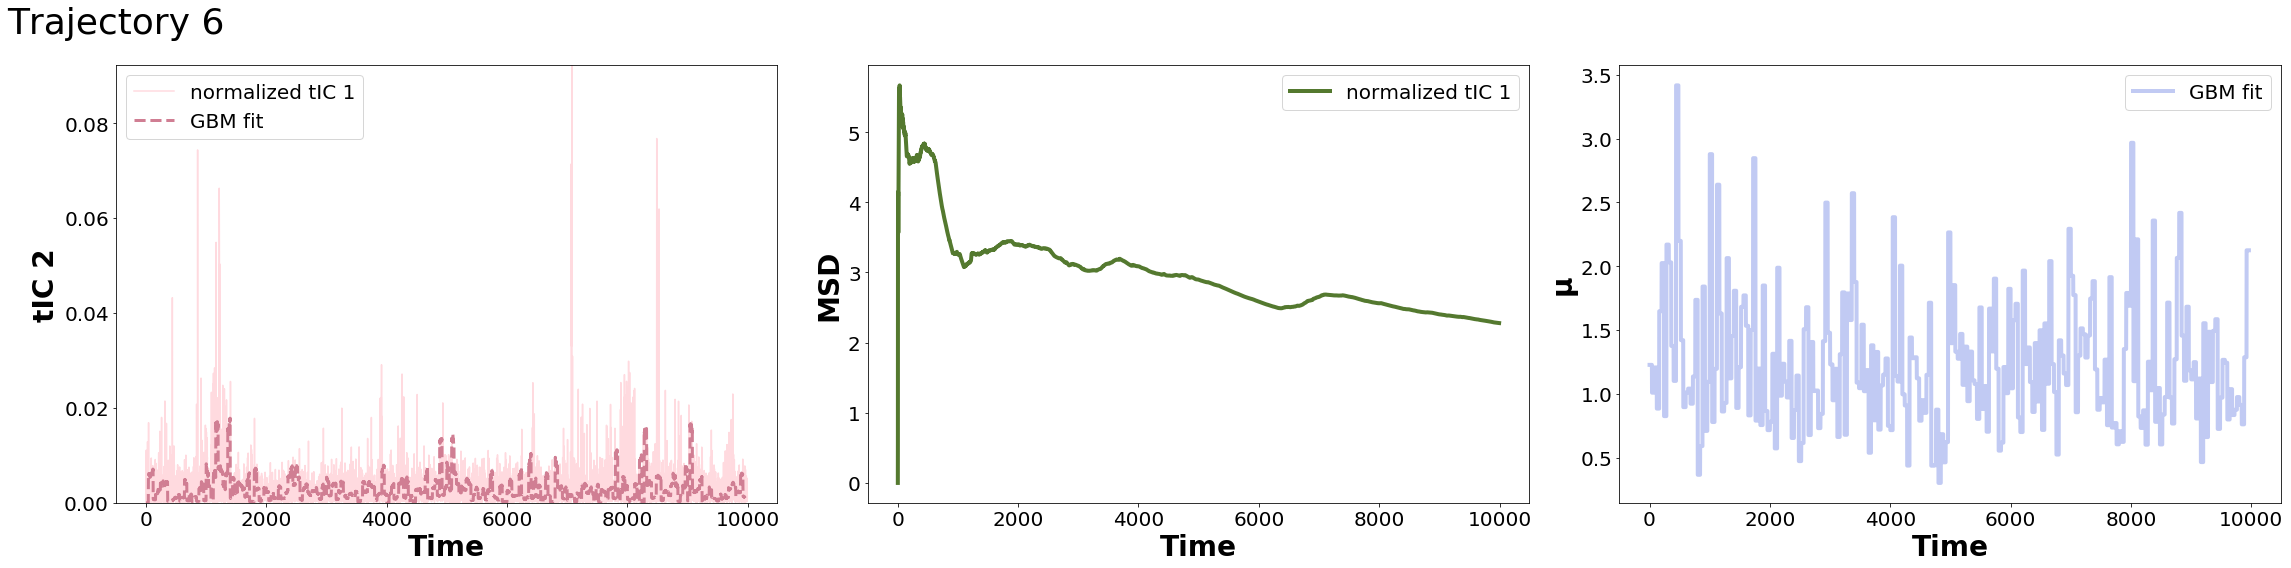

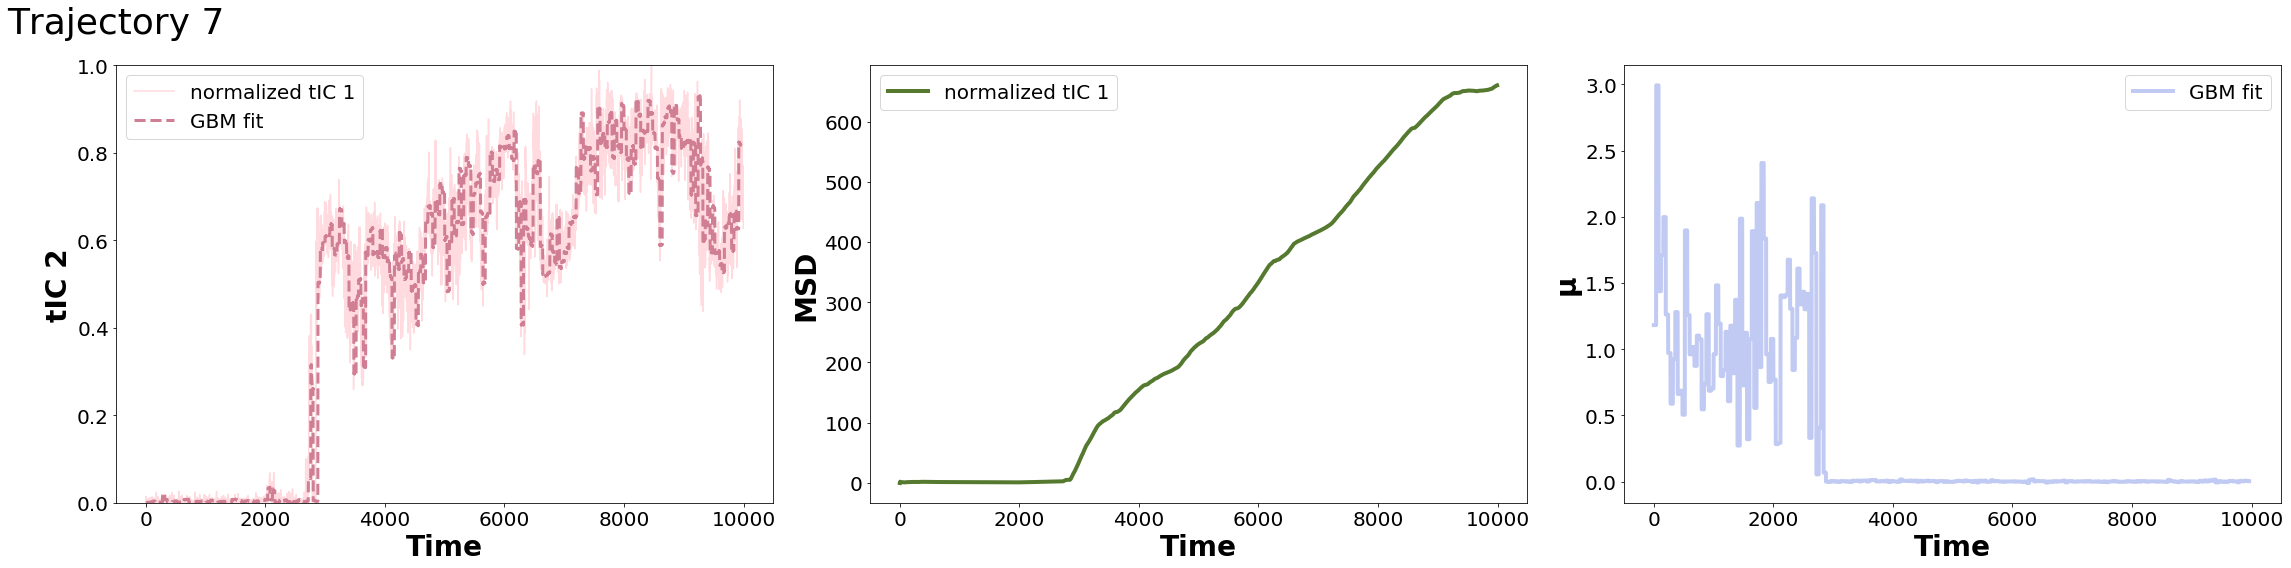

In [26]:
hg = 1  # the portion of the trajectory analyzed  (with 1 for using the whole length)
# tICA component 2

mu_1y = []
sigma2_1 = []
diff_2y = []
lag = 40
m_av = []
R = []
for i in range(8):
    shape = norm_abs_data_y[i].shape[0]//hg
    ss = []
    m = []
    for j in range(shape//lag):
        data1 = norm_abs_data_y[i][j*lag+1:(j+1)*lag]
        t = np.arange((j*lag+1)//10000, (j+1)*lag/10000)

        # Specify the data to be used in GBM analysis
        data  = data1
        xx = np.sum(np.log(data[1:]/data[:-1])[1:])  
        x_f = xx/data.shape[0]
        s = (1/(data.shape[0]-1))*np.sum((np.log(data[1:]/data[:-1])[1:]-x_f)**2)
        sigma3 = (s)**0.5
        mu3 = x_f+0.5*sigma3**2
        mu3 = round(mu3, 4)
        sigma2 = round(0.5*sigma3**2, 4)
        for g in range(lag):
            ss.append(sigma2)
            m.append(mu3)
    sigma2_1.append(np.asarray(ss))
    mu_1y.append(np.asarray(m))
    fig, ax = plt.subplots(figsize = (32, 8), ncols = 3, nrows = 1, sharex = True)
    ax[0].set_title('Trajectory '+str(i), x = 0, y=1.06, fontsize = 36)

    ax[2].plot(mu_1y[i], color = colors[8], lw = 4, label = 'GBM fit', zorder = 0)    
    ax[0].plot(norm_abs_data_y[i], color = 'lightpink', alpha = 0.5, label = 'normalized tIC 1')
    ax[1].plot(A[i], color = colors[4], lw = 4, label = 'normalized tIC 1')
    ax[1].set_ylabel("MSD", {'weight':'semibold'}, fontsize = 28)
    ax[2].set_ylabel(u"\u03bc", {'weight':'semibold'}, fontsize = 28)      
    XX = []
    TT = []
    for j in range(shape//lag):
        x0 = norm_abs_data_y[i][j*lag]
        mu3 = np.average(mu_1y[i][j*lag])
        sigma3 = np.average(sigma2_1[i][j*lag])
        dt = 0.0001

        t = np.arange(j*lag+1, (j+1)*lag)
        x = np.exp(
        (mu3 - sigma3 ) * dt
        + (2*sigma3**0.5) * np.random.normal(0, np.sqrt(dt), size=(len([sigma3]), lag-2)).T)
        x = np.vstack([np.ones(len([sigma3])), x])
        x = x0 * x.cumprod(axis=0)
        XX.append(x[:, 0])
        TT.append(t)
    ax[0].plot(np.concatenate(TT)-1, np.concatenate(XX), color = colors[6], lw = 3, linestyle = '--', label = 'GBM fit')
    ax[0].set_ylim(0, np.max(norm_abs_data_y[i]))
    ax[0].set_ylabel("tIC 2", {'weight':'semibold'}, fontsize = 28)
    plt.legend()
    for a in ax:
        a.legend(loc = 'best', prop = {'size': 20})
        a.set_xlabel('Time', {'weight':'semibold'}, fontsize = 28)
        a.tick_params(labelsize = 20)
    fig.tight_layout()


# Save the mus for each of the trajectories and get the frame number of the beginning of the last diffusion stage

In [160]:
for i in range(60):
    np.savetxt('mu_y_'+str(i)+'.txt', mu_1y[i])
    np.savetxt('mu_x_'+str(i)+'.txt', mu_1x[i])

Last state not sufficiently sampled!

Last state not sufficiently sampled!

Last state not sufficiently sampled!



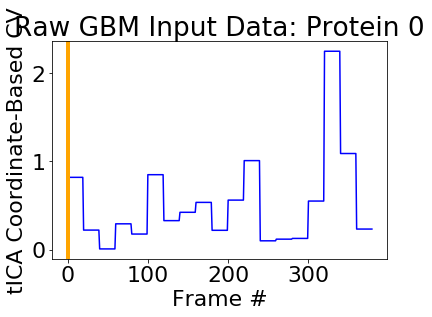

traj 0
# of states:2 start frame #:80


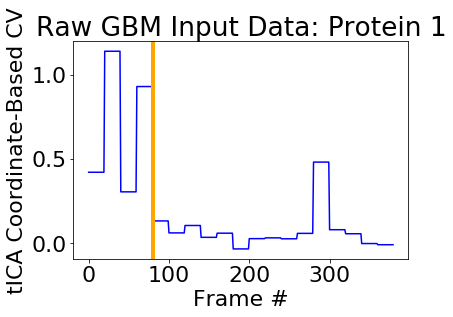

traj 1
# of states:4 start frame #:51


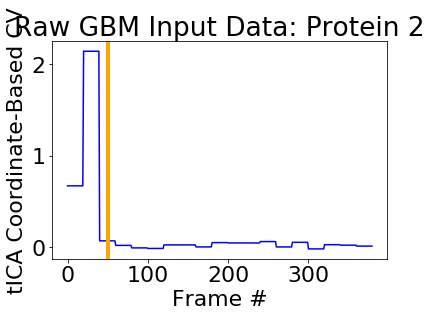

traj 2
Last state not sufficiently sampled!

Last state not sufficiently sampled!

Last state not sufficiently sampled!



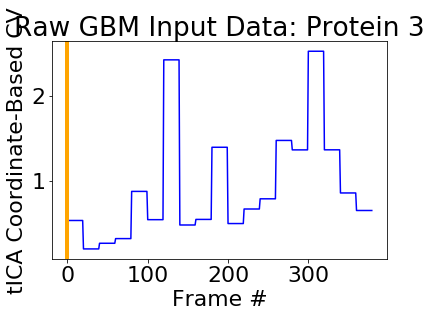

traj 3
# of states:3 start frame #:51


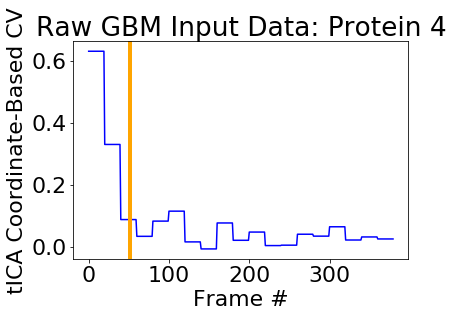

traj 4
Last state not sufficiently sampled!

Last state not sufficiently sampled!

Last state not sufficiently sampled!



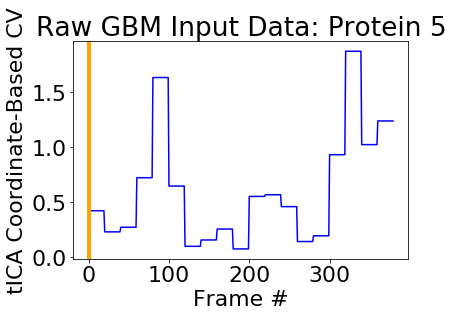

traj 5
Last state not sufficiently sampled!

Last state not sufficiently sampled!

Last state not sufficiently sampled!



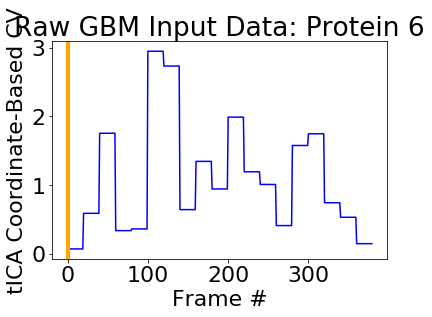

traj 6
Last state not sufficiently sampled!



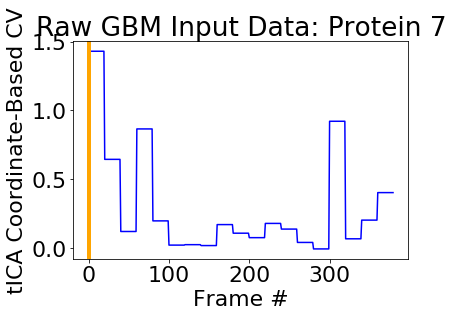

traj 7
# of states:3 start frame #:82


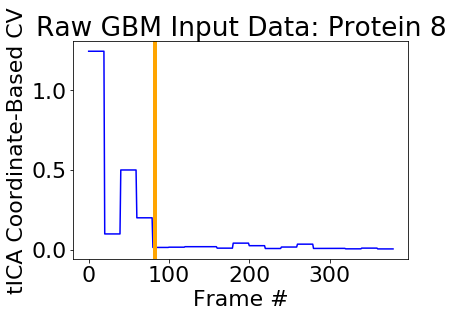

traj 8
Last state not sufficiently sampled!

Last state not sufficiently sampled!

Last state not sufficiently sampled!



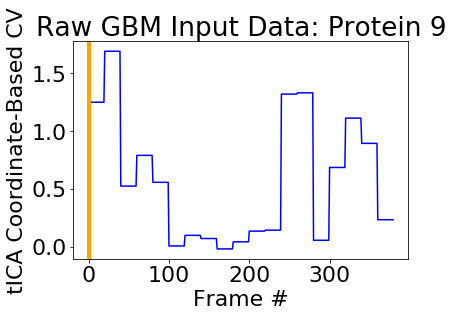

traj 9


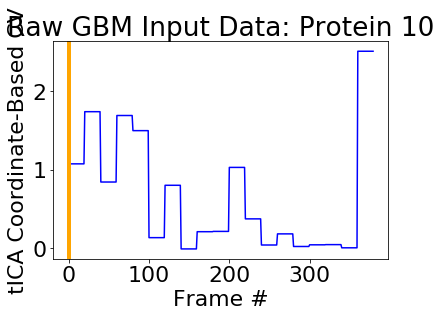

traj 10
Last state not sufficiently sampled!

Last state not sufficiently sampled!

Last state not sufficiently sampled!



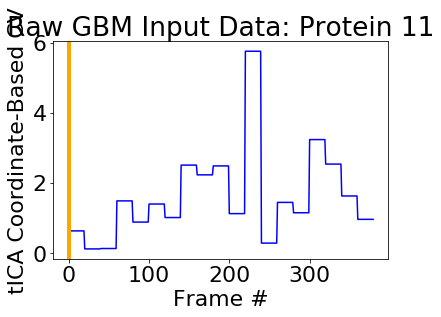

traj 11
Last state not sufficiently sampled!

# of states:2 start frame #:140


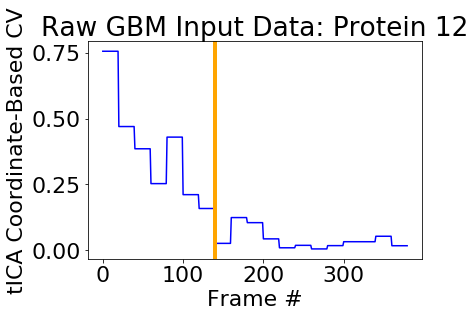

traj 12
Last state not sufficiently sampled!

Last state not sufficiently sampled!



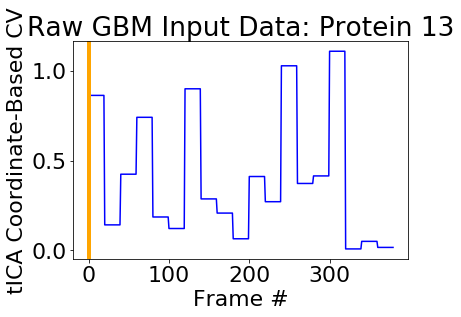

traj 13
# of states:2 start frame #:1


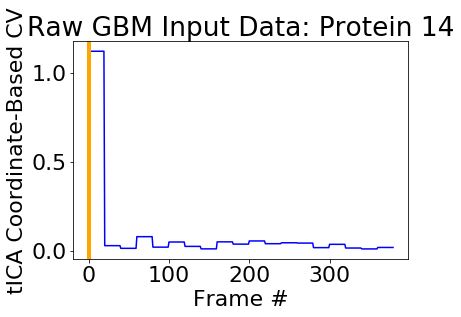

traj 14
Last state not sufficiently sampled!

Last state not sufficiently sampled!

Last state not sufficiently sampled!



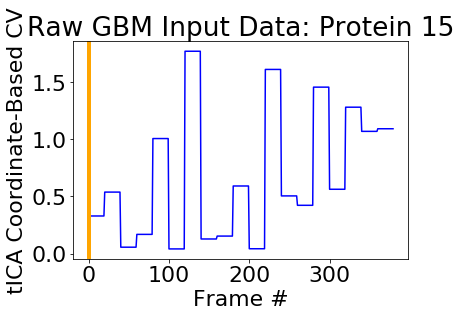

traj 15
Last state not sufficiently sampled!

Last state not sufficiently sampled!



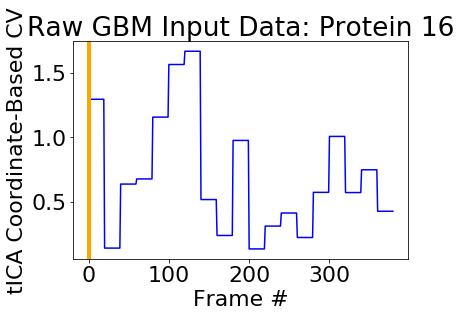

traj 16
Last state not sufficiently sampled!

Last state not sufficiently sampled!



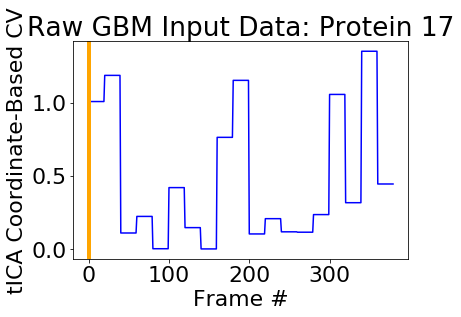

traj 17
# of states:4 start frame #:52


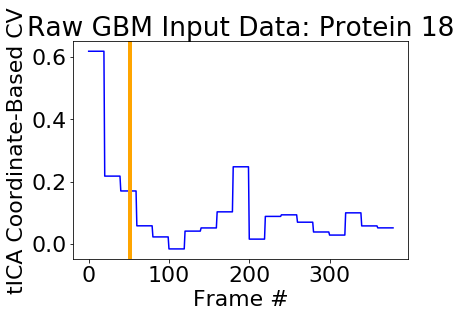

traj 18
Last state not sufficiently sampled!

Last state not sufficiently sampled!



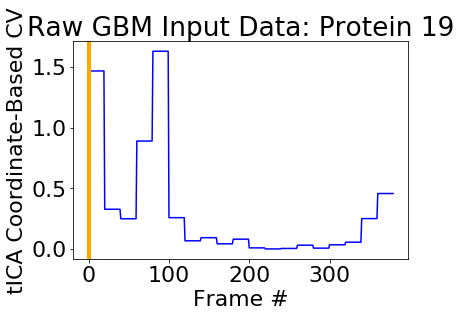

traj 19
Last state not sufficiently sampled!

Last state not sufficiently sampled!

Last state not sufficiently sampled!



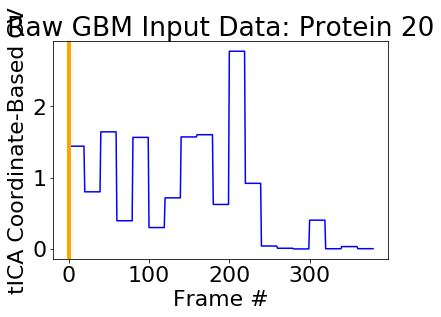

traj 20
Last state not sufficiently sampled!

Last state not sufficiently sampled!



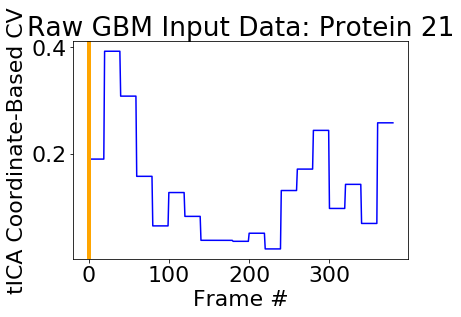

traj 21
Last state not sufficiently sampled!

Last state not sufficiently sampled!



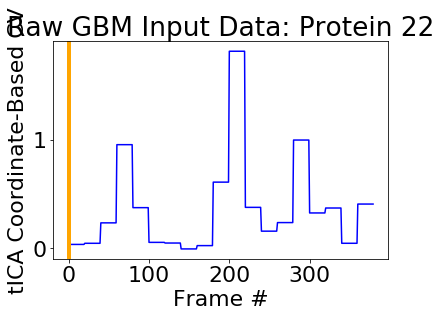

traj 22
Last state not sufficiently sampled!

Last state not sufficiently sampled!



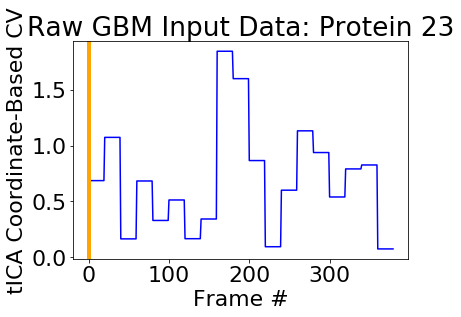

traj 23
Last state not sufficiently sampled!

Last state not sufficiently sampled!

Last state not sufficiently sampled!



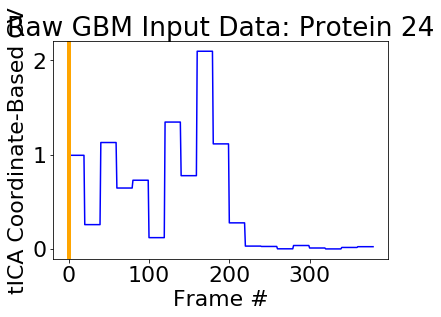

traj 24
Last state not sufficiently sampled!

# of states:2 start frame #:122


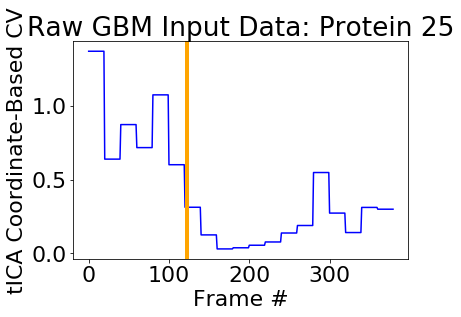

traj 25
# of states:4 start frame #:101


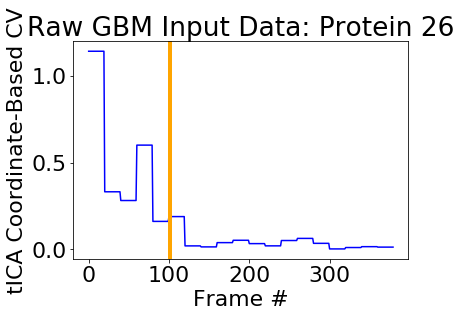

traj 26
Last state not sufficiently sampled!



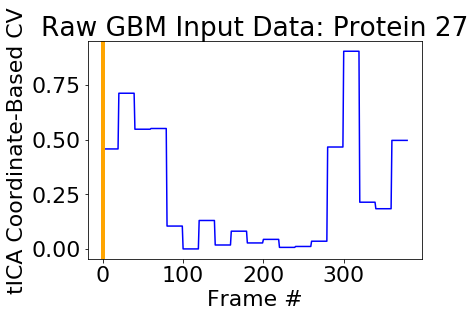

traj 27
# of states:2 start frame #:1


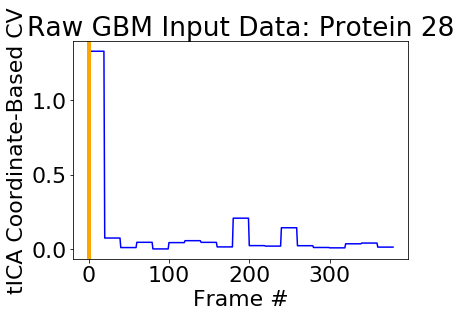

traj 28
Last state not sufficiently sampled!

Last state not sufficiently sampled!



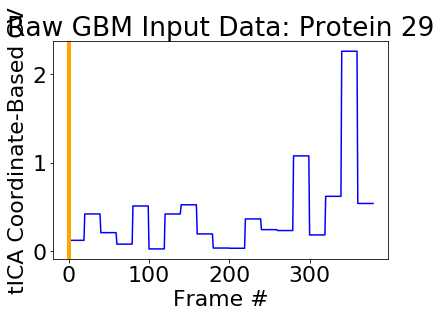

traj 29
# of states:4 start frame #:90


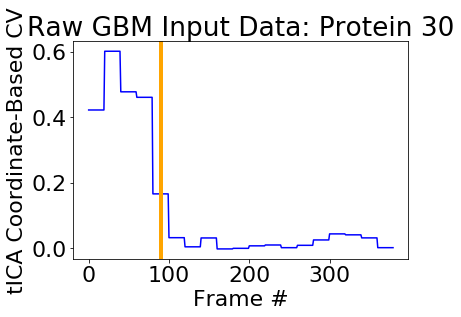

traj 30
Last state not sufficiently sampled!

# of states:3 start frame #:50


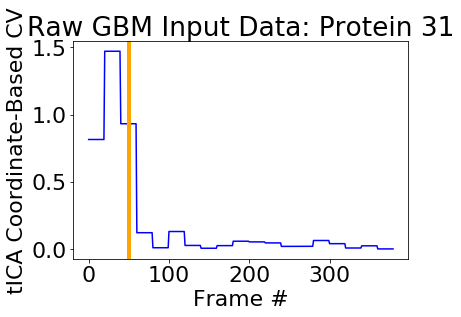

traj 31
Last state not sufficiently sampled!

Last state not sufficiently sampled!

Last state not sufficiently sampled!



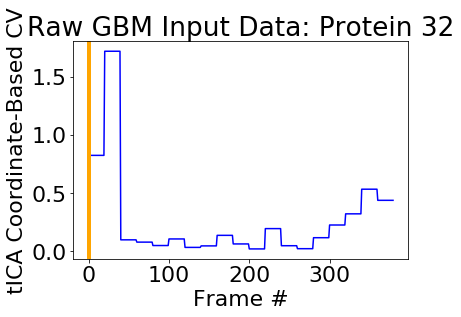

traj 32
# of states:4 start frame #:72


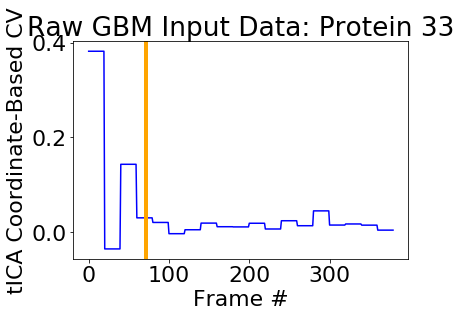

traj 33
Last state not sufficiently sampled!



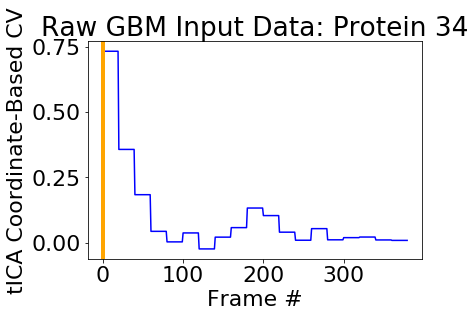

traj 34
# of states:3 start frame #:82


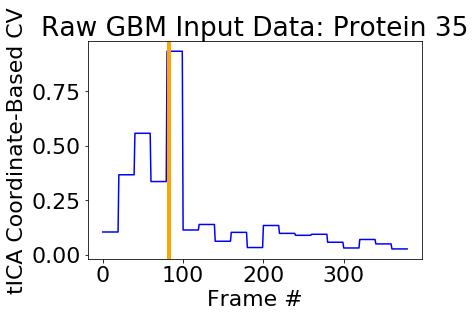

traj 35
Last state not sufficiently sampled!

Last state not sufficiently sampled!



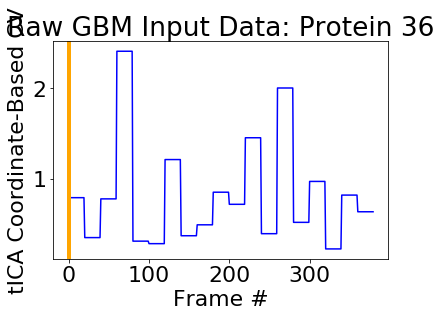

traj 36
Last state not sufficiently sampled!

Last state not sufficiently sampled!



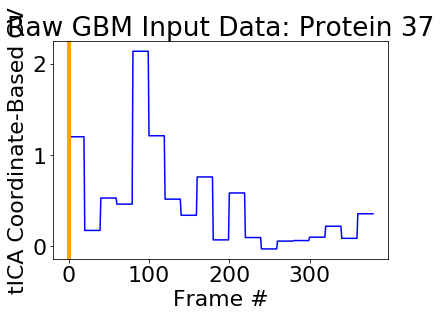

traj 37
Last state not sufficiently sampled!

Last state not sufficiently sampled!

Last state not sufficiently sampled!



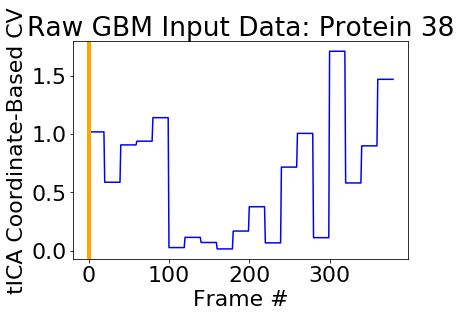

traj 38
Last state not sufficiently sampled!

Last state not sufficiently sampled!



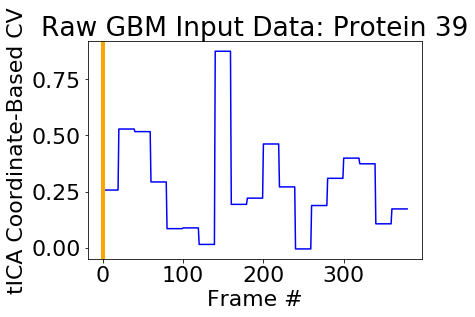

traj 39
Last state not sufficiently sampled!

# of states:3 start frame #:80


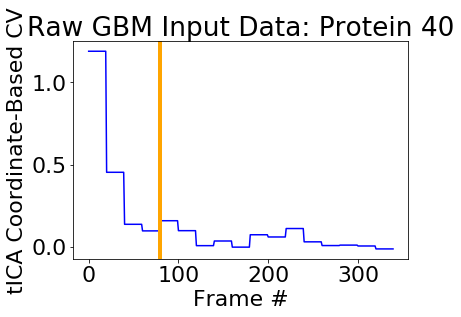

traj 40
# of states:2 start frame #:80


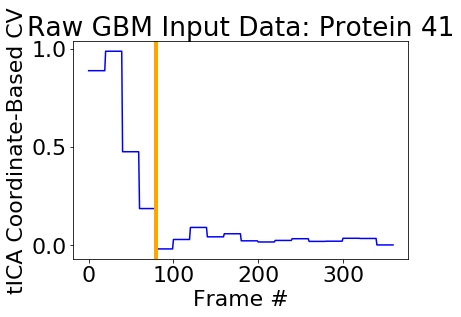

traj 41


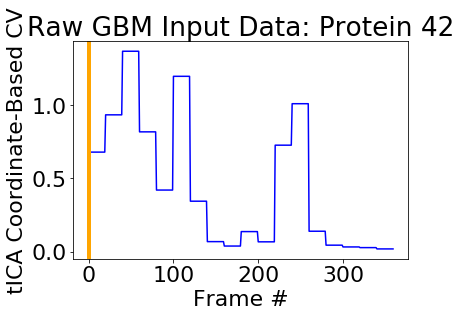

traj 42
Last state not sufficiently sampled!

Last state not sufficiently sampled!



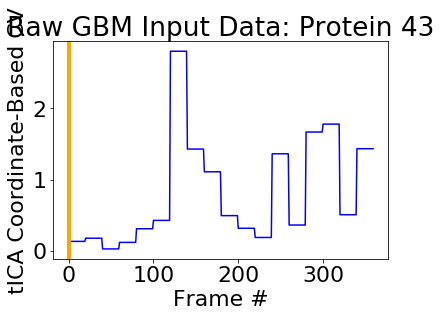

traj 43
Last state not sufficiently sampled!

Last state not sufficiently sampled!

# of states:2 start frame #:1


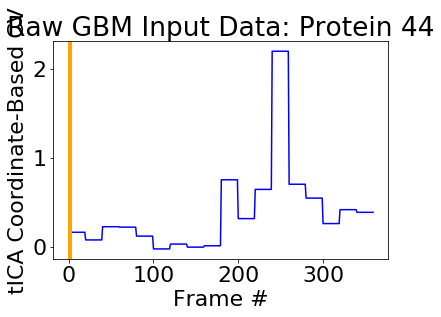

traj 44
# of states:4 start frame #:50


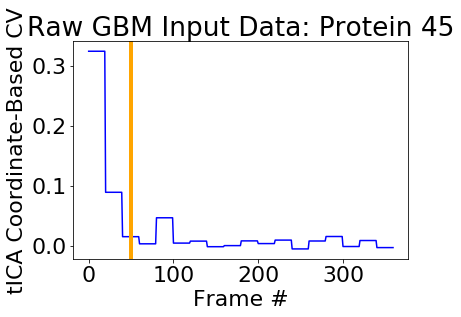

traj 45
Last state not sufficiently sampled!

Last state not sufficiently sampled!

Last state not sufficiently sampled!



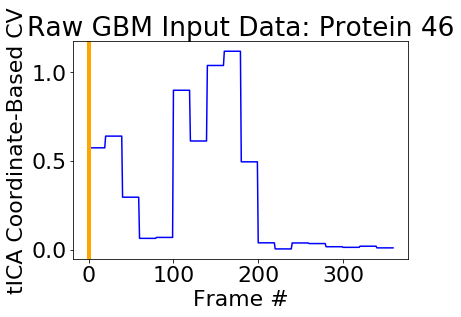

traj 46
Last state not sufficiently sampled!

Last state not sufficiently sampled!

Last state not sufficiently sampled!



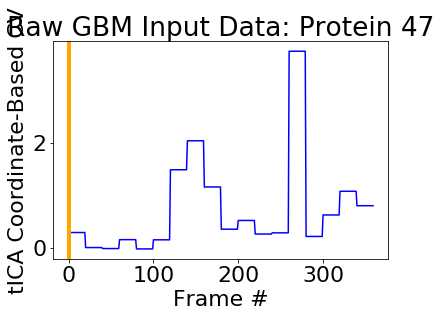

traj 47
Last state not sufficiently sampled!

Last state not sufficiently sampled!

Last state not sufficiently sampled!



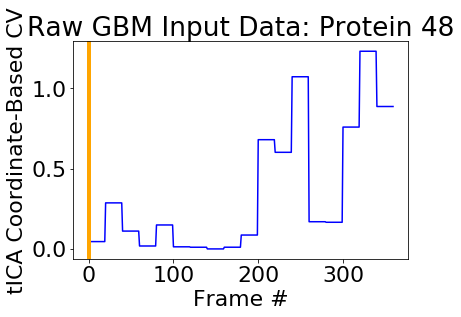

traj 48
Last state not sufficiently sampled!

Last state not sufficiently sampled!

# of states:2 start frame #:1


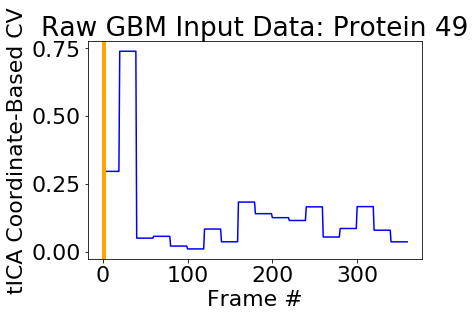

traj 49
Last state not sufficiently sampled!



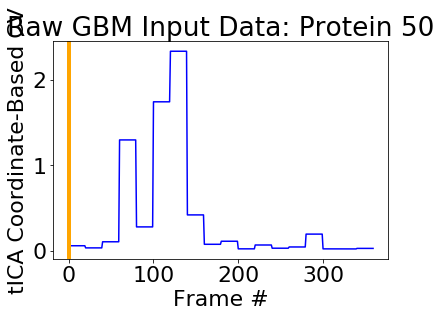

traj 50
Last state not sufficiently sampled!

Last state not sufficiently sampled!

Last state not sufficiently sampled!



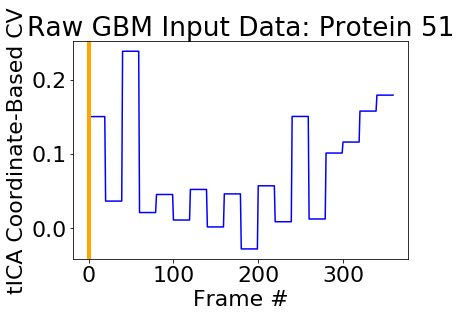

traj 51
Last state not sufficiently sampled!

Last state not sufficiently sampled!

Last state not sufficiently sampled!



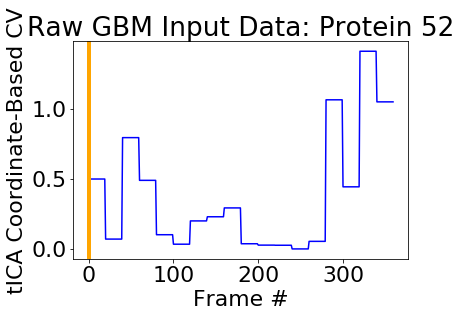

traj 52
Last state not sufficiently sampled!

Last state not sufficiently sampled!

# of states:2 start frame #:120


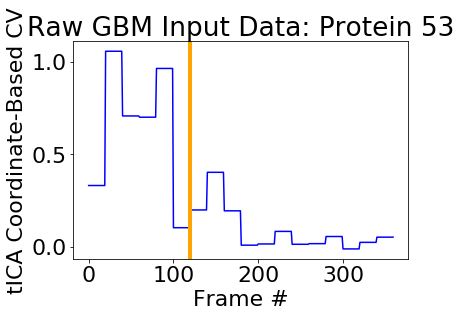

traj 53
# of states:4 start frame #:132


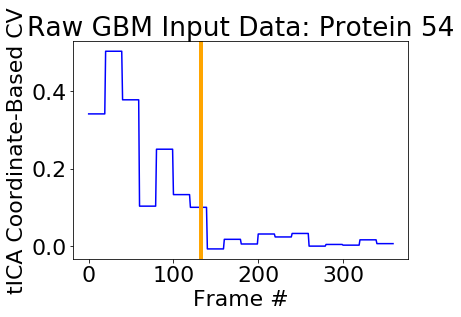

traj 54
Last state not sufficiently sampled!

# of states:2 start frame #:82


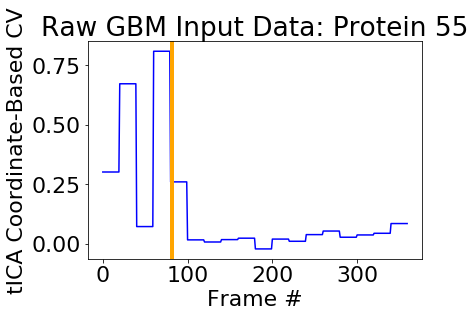

traj 55
Last state not sufficiently sampled!

Last state not sufficiently sampled!



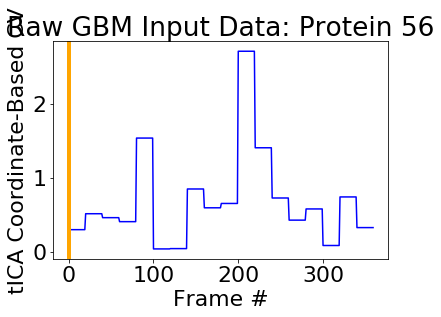

traj 56
Last state not sufficiently sampled!

Last state not sufficiently sampled!



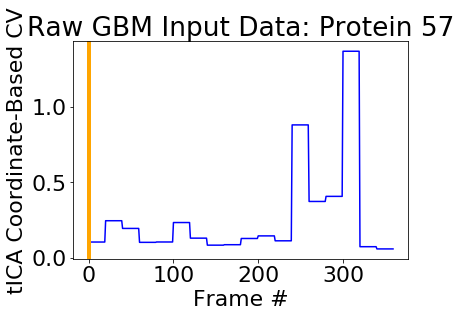

traj 57
# of states:2 start frame #:1


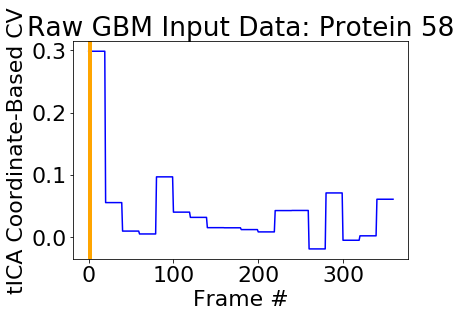

traj 58
Last state not sufficiently sampled!

Last state not sufficiently sampled!



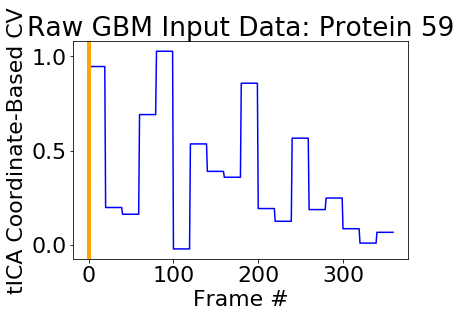

traj 59


In [167]:
states_x, states_y = ([] for i in range(2))
for i in range(60):
    gx = np.loadtxt('mu_x_'+str(i)+'.txt')
    gy = np.loadtxt('mu_y_'+str(i)+'.txt')
    
    gx = gx.reshape(gx.shape[0], 1)
    gy = gy.reshape(gy.shape[0], 1)
    tx = np.arange(gx.shape[0])
    ty = np.arange(gy.shape[0])
    kx = get_window_start(gx, 50)
    ky = get_window_start(gy, 50)
    states_x.append(kx)
    states_y.append(ky)
np.savetxt('mux_states.txt', states_x)
np.savetxt('muy_states.txt', states_y)

# Evaluate the average mus for the last regime of  trajectories

In [121]:
mux_av, muy_av = ([] for i in range(2))
for i in range(60):
    mux_av.append(np.average(mu_1x[i][states_x[i]:]))
    muy_av.append(np.average(mu_1y[i][states_y[i]:]))

In [188]:
dfx = pd.DataFrame(np.stack((mux_av, np.arange(60).tolist()), axis = -1), columns = ['tIC 1','traj_n'])
dfx['segment'] = 60*['A']

dfy = pd.DataFrame(np.stack((muy_av, np.arange(60).tolist()), axis = -1), columns = ['tIC 2','traj_n'])
dfy['segment'] = 60*['A']

In [191]:
AX = dfx.sort_values(['tIC 1'])

AY = dfy.sort_values(['tIC 2'])

In [198]:
# Save sorted trajectories and correponding mu
AX.to_csv('/your_path/sorted-tIC1.csv')
AY.to_csv('/your_path/sorted-tIC2.csv')